In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set()
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
np.random.seed(1)
from calendar import monthrange
import random
import tensorflow as tf
np.random.seed(28)
random.seed(28)
tf.random.set_seed(28)

In [ ]:
def train_and_validate_fixed_years(model, data, configs):
    train_data = data[data.index.year.isin([2019, 2020])]
    val_data = data[data.index.year == 2021]
    
    results = []
    for config in configs:

        result = model(10, train_data.append(val_data), 1, config)  
        results.append((config, result))
    
    return results

configs = [config1,config2,config3,config4,config5,config6
    #{'layers': 2, 'units': 50, 'return_sequence': True, 'recurrent_dropout': 0.2, 'dense_layers': [50], 'dense_dropout': 0.2},
    # ... otras configuraciones ...
]
results = train_and_validate_fixed_years(LSTMDemandaDiariaPorMesesConfig, dataFullCaracteristicas, configs)
results



# Importante

Para las redes neuronales estamos usandos Keras, el cual requiere de tensorflow en el back para poder usarse. Antes de correr ciertos algoritmos se deberá tener configurado el entorno.


pip install keras

pip install tensorflow

pip install pmdarima


Primero leemos los dataset por separado. Luego iremos formando diferentes dataset dependiendo del uso que necesitemos. En este caso los dataset inciales son oficiales por lo que se les ha realizado un pequeño preprocesado, es por ello que no se realiza la busqueda de null, ceros u otros valores que afecten al dataset.

Los dataset iniciales son de la demanda y la producción en bruto de la energía en Iraq por países. Para este proyecto se hará de la totalidad del país, es decir la suma de todos los piases y se analizarán como una serie de tiempo

In [2]:
datosDemandaBruto = pd.read_csv("Demand13.csv")
datosProduccionBruto = pd.read_csv("Supply13.csv")

In [3]:
print(datosDemandaBruto)
datosDemandaBruto.head()

       Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1     3294   1243     757          488    471    598    525    514   
1          2     2973   1151     753          477    436    570    500    469   
2          3     2758   1105     727          471    419    604    478    430   
3          4     2703   1220     717          470    463    564    497    465   
4          5     2954   1358     751          519    515    626    553    517   
...      ...      ...    ...     ...          ...    ...    ...    ...    ...   
26347     20     4894   1906    1206         1008    912   1112   1112    914   
26348     21     4550   1798    1158          928    862   1047   1027    869   
26349     22     4326   1683    1091          868    818   1001    972    807   
26350     23     4090   1567     988          819    782    935    892    780   
26351     24     3954   1465     942          780    750    879    838    728   

       Najaf  Dywan.  Wasit

Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0      1     3294   1243     757          488    471    598    525    514   
1      2     2973   1151     753          477    436    570    500    469   
2      3     2758   1105     727          471    419    604    478    430   
3      4     2703   1220     717          470    463    564    497    465   
4      5     2954   1358     751          519    515    626    553    517   

   Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesan  Basrah  
0    474     307    404      208      573    369    1254  
1    437     284    374      193      536    342    1100  
2    420     273    359      185      519    328    1056  
3    451     301    397      204      522    363    1100  
4    502     335    442      228      574    404    1298

In [4]:
print(datosProduccionBruto)
datosProduccionBruto.head()

       Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1   3294    740     668          488    394    598    525    514   
1          2   2973    751     753          477    387    570    500    469   
2          3   2758    760     727          471    374    604    478    430   
3          4   2703    759     717          470    365    546    490    433   
4          5   2794    727     751          470    374    578    539    472   
...      ...    ...    ...     ...          ...    ...    ...    ...    ...   
26347     20   3364    765     762          418    421    587    648    608   
26348     21   3437    748     751          412    418    617    678    638   
26349     22   3368    761     751          420    411    603    719    689   
26350     23   3373    801     782          424    406    614    663    681   
26351     24   3169    853     759          422    404    604    568    593   

       Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesa

Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0      1   3294    740     668          488    394    598    525    514   
1      2   2973    751     753          477    387    570    500    469   
2      3   2758    760     727          471    374    604    478    430   
3      4   2703    759     717          470    365    546    490    433   
4      5   2794    727     751          470    374    578    539    472   

   Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesan  Basrah  
0    474     246    397      185      573    294    1104  
1    437     223    362      177      536    269    1030  
2    420     210    347      169      519    229     956  
3    420     202    350      172      522    232     953  
4    449     246    389      191      574    275    1003

Para el total de horas sumaremos el valor de todas las columna, ya que cada columna representa el valor de cada provincia, creando una nueva columna con esto mismo.

In [5]:
datosDemandaTotalHoras = pd.DataFrame()
datosProduccionTotalHoras = pd.DataFrame()

In [6]:
datosDemandaTotalHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [7]:
datosDemandaTotalHoras["Hours"] = datosDemandaBruto["Hours"]
datosProduccionTotalHoras["Hours"] = datosProduccionBruto["Hours"]

In [8]:
datosDemandaTotalSinHoras = pd.DataFrame()
datosProduccionTotalSinHoras = pd.DataFrame()

In [9]:
datosDemandaTotalSinHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalSinHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [10]:
datosDemandaTotalHoras.head()


total  Hours
0  11479      1
1  10595      2
2  10132      3
3  10437      4
4  11576      5

In [11]:
datosDemandaTotalSinHoras.head()

total
0  11479
1  10595
2  10132
3  10437
4  11576

Ahora partimos de un nuevo dataset el cual tiene una columna con las demanda/produccion por horas, es decir cada fila es una hora y cada 24 filas es un día. Una vez tenemos estos dos dataset, vamos a pasar estas horas a dias para tener los otros dos dataset faltantes.

In [12]:
suma_24_demanda = []
suma_24_produccion = []

In [13]:
for i in range(0, len(datosDemandaTotalSinHoras), 24):
    end = i + 24
    if end > len(datosDemandaTotalSinHoras):
        end = len(datosDemandaTotalSinHoras)
    suma_24_demanda.append(datosDemandaTotalSinHoras[i:end].sum(axis=0).sum())

In [14]:
for i in range(0, len(datosProduccionTotalSinHoras), 24):
    end = i + 24
    if end > len(datosProduccionTotalSinHoras):
        end = len(datosProduccionTotalSinHoras)
    suma_24_produccion.append(datosProduccionTotalSinHoras[i:end].sum(axis=0).sum())

In [15]:
datosDemandaTotalDias = pd.DataFrame({'Total': suma_24_demanda})
datosProduccionTotalDias = pd.DataFrame({'Total': suma_24_produccion})

In [16]:
diasDemanda = pd.date_range(start='2019-01-01', periods=len(suma_24_demanda), freq='D')
diasProduccion = pd.date_range(start='2019-01-01', periods=len(suma_24_produccion), freq='D')

In [17]:
datosDemandaTotalDias["fecha"] = diasDemanda
datosProduccionTotalDias["fecha"] = diasProduccion

Despues de hacer todas estas transformaciones ya tenemos los 4 dataset que queremos: datosDemandaTotalHoras/datosProduccionTotalHoras los cuales tiene la produccion total por ahora y datosDemandaTotalDias/datosProduccionTotalDias los cuales tienen la produccion por dias

In [18]:
datosDemandaTotalHoras.head()


total  Hours
0  11479      1
1  10595      2
2  10132      3
3  10437      4
4  11576      5

In [19]:
datosProduccionTotalHoras.head()

total  Hours
0  10494      1
1   9914      2
2   9452      3
3   9334      4
4   9832      5

In [20]:
datosHorariosDemanda = datosDemandaTotalHoras.rename(columns={'total': 'Demanda'})
datosHorariosDemanda

Demanda  Hours
0        11479      1
1        10595      2
2        10132      3
3        10437      4
4        11576      5
...        ...    ...
26347    19725     20
26348    18376     21
26349    17323     22
26350    16220     23
26351    15341     24

[26352 rows x 2 columns]

In [21]:
datosHorariosProduccion = datosProduccionTotalHoras.rename(columns={'total': 'Produccion'})
datosHorariosProduccion

Produccion  Hours
0           10494      1
1            9914      2
2            9452      3
3            9334      4
4            9832      5
...           ...    ...
26347       12754     20
26348       12639     21
26349       12320     22
26350       11802     23
26351       11000     24

[26352 rows x 2 columns]

In [22]:
datosHorariosProduccion['Demanda'] = datosHorariosDemanda['Demanda']
datosHorariosProduccion

Produccion  Hours  Demanda
0           10494      1    11479
1            9914      2    10595
2            9452      3    10132
3            9334      4    10437
4            9832      5    11576
...           ...    ...      ...
26347       12754     20    19725
26348       12639     21    18376
26349       12320     22    17323
26350       11802     23    16220
26351       11000     24    15341

[26352 rows x 3 columns]

In [23]:
datosDemandaTotalDias.head()

Total      fecha
0  379726 2019-01-01
1  383590 2019-01-02
2  378901 2019-01-03
3  378180 2019-01-04
4  385805 2019-01-05

In [24]:
datosProduccionTotalDias.head()

Total      fecha
0  289005 2019-01-01
1  288843 2019-01-02
2  283581 2019-01-03
3  285621 2019-01-04
4  283991 2019-01-05

In [25]:
data = pd.merge(datosDemandaTotalDias, datosProduccionTotalDias, on='fecha')

In [26]:
data = data.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})

In [27]:
data = data.set_index('fecha')

In [28]:
data


Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-29   411592      261122
2021-12-30   378184      248905
2021-12-31   414996      257533
2022-01-01   437452      272710
2022-01-02   417780      277922

[1098 rows x 2 columns]

# Estudio de estaciones

Después de informarme un poco sobre el país, he cogido las 4 estaciones según los meses para ver si hay alguna relación. De primera intuición podemos imaginar que a ser un país caluroso en verano y fresco en invierno, en estas estaciones deberíamos tener mayor demanda en estos periodos

In [53]:
estaciones = {
    1: 'Invierno',
    2: 'Invierno',
    3: 'Invierno',
    4: 'Primavera',
    5: 'Primavera',
    6: 'Verano',
    7: 'Verano',
    8: 'Verano',
    9: 'Verano',
    10: 'Otoño',
    11: 'Otoño',
    12: 'Invierno'
}

In [54]:
dataEstacion = data.copy()

In [55]:
dataEstacion['estacion'] = data.index.month.map(estaciones)

In [56]:
dataEstacion.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2019-01-01 to 2022-01-02
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Demanda     1098 non-null   int64 
 1   Produccion  1098 non-null   int64 
 2   estacion    1098 non-null   object
dtypes: int64(2), object(1)
memory usage: 66.6+ KB


In [64]:
dataEstacion

Demanda  Produccion  estacion
fecha                                    
2019-01-01   379726      289005  Invierno
2019-01-02   383590      288843  Invierno
2019-01-03   378901      283581  Invierno
2019-01-04   378180      285621  Invierno
2019-01-05   385805      283991  Invierno
...             ...         ...       ...
2021-12-29   411592      261122  Invierno
2021-12-30   378184      248905  Invierno
2021-12-31   414996      257533  Invierno
2022-01-01   437452      272710  Invierno
2022-01-02   417780      277922  Invierno

[1098 rows x 3 columns]

In [58]:
dataEstacion2 = dataEstacion.copy()

In [59]:
dataEstacion2.groupby(['estacion'])['Demanda'].mean()

estacion
Invierno     368132.762295
Otoño        342338.863388
Primavera    365714.278689
Verano       540844.855191
Name: Demanda, dtype: float64

In [60]:
dataEstacion2.groupby(['estacion'])['Produccion'].mean()

estacion
Invierno     268142.710383
Otoño        283917.808743
Primavera    306742.420765
Verano       403776.814208
Name: Produccion, dtype: float64

<AxesSubplot:xlabel='fecha'>

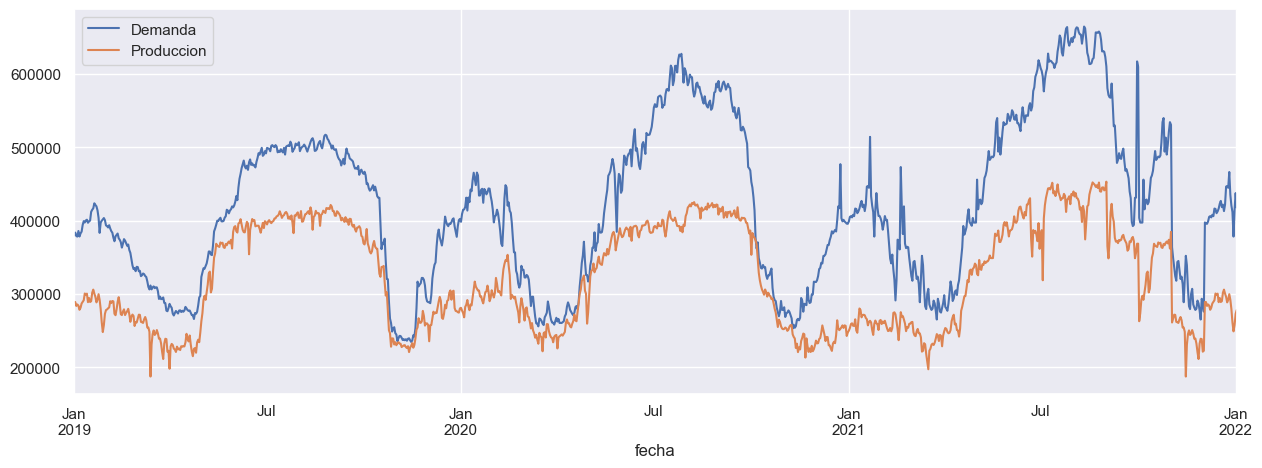

In [61]:
dataEstacion2.plot(figsize=(15,5))

Ahora vamos a entrenar una red LSTM con los años 2019 y 2020 para ver si es capaz de predecir las estaciones en 2021
Para ello con convertiremos las etiquetas de estaciones del año a una forma numérica (codificación one-hot) para que el modelo pueda entenderlas.
Se va a probar con ventanas de 7,30,60,100,180 dias  
Todo esto cogiendo una sola caracteristica luego, la realizaré con las dos para comparar resultados



In [103]:
dataLSTMEstacion = dataEstacion.copy()

In [104]:
#dataLSTMEstacion.to_csv("aa.csv", index=False)

In [105]:
dataLSTMEstacion

Demanda  Produccion  estacion
fecha                                    
2019-01-01   379726      289005  Invierno
2019-01-02   383590      288843  Invierno
2019-01-03   378901      283581  Invierno
2019-01-04   378180      285621  Invierno
2019-01-05   385805      283991  Invierno
...             ...         ...       ...
2021-12-29   411592      261122  Invierno
2021-12-30   378184      248905  Invierno
2021-12-31   414996      257533  Invierno
2022-01-01   437452      272710  Invierno
2022-01-02   417780      277922  Invierno

[1098 rows x 3 columns]

In [114]:
def estaciones_LSTM_demanda(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))
    #reciclo la función, podría crearla arriba y llamarla, pero en todas tengo que hacer pequeños cambios, para futuras mejoras
    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]
    #solo cojo la demanda para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Demanda']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    #para mostrar resultados
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))


In [115]:
estaciones_LSTM_demanda(dataLSTMEstacion, 7)


Epoch 1/20
23/23 [==============================] - 5s 51ms/step - loss: 1.8280 - accuracy: 0.1669 - val_loss: 1.6950 - val_accuracy: 0.1694
Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 1.6065 - accuracy: 0.1669 - val_loss: 1.5297 - val_accuracy: 0.1694
Epoch 3/20
23/23 [==============================] - 0s 19ms/step - loss: 1.4749 - accuracy: 0.1669 - val_loss: 1.4302 - val_accuracy: 0.3222
Epoch 4/20
23/23 [==============================] - 1s 26ms/step - loss: 1.4013 - accuracy: 0.3324 - val_loss: 1.3780 - val_accuracy: 0.3222
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 1.3616 - accuracy: 0.3324 - val_loss: 1.3529 - val_accuracy: 0.3222
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 1.3433 - accuracy: 0.3324 - val_loss: 1.3412 - val_accuracy: 0.3222
Epoch 7/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3355 - accuracy: 0.3324 - val_loss: 1.3363 - val_accuracy: 0.3222
Epoch 8/20
23

In [116]:
def estaciones_LSTM_produccion(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))
    #reciclo la función, podría crearla arriba y llamarla, pero en todas tengo que hacer pequeños cambios, para futuras mejoras
    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]
    #solo cojo la produccion para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Produccion']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    #para mostrar resultados
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))


In [117]:
estaciones_LSTM_produccion(dataLSTMEstacion, 7)

Epoch 1/20
23/23 [==============================] - 4s 44ms/step - loss: 1.3503 - accuracy: 0.3324 - val_loss: 1.3385 - val_accuracy: 0.3222
Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 1.3338 - accuracy: 0.3324 - val_loss: 1.3336 - val_accuracy: 0.3389
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3312 - accuracy: 0.3078 - val_loss: 1.3335 - val_accuracy: 0.3389
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3312 - accuracy: 0.3338 - val_loss: 1.3335 - val_accuracy: 0.3389
Epoch 5/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3305 - accuracy: 0.2955 - val_loss: 1.3335 - val_accuracy: 0.3222
Epoch 6/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3308 - accuracy: 0.3051 - val_loss: 1.3334 - val_accuracy: 0.3389
Epoch 7/20
23/23 [==============================] - 0s 18ms/step - loss: 1.3306 - accuracy: 0.3338 - val_loss: 1.3334 - val_accuracy: 0.3389
Epoch 8/20
23/23

In [77]:
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))

In [81]:
def dataset_X(X, look_back):
    dataX = []
    for i in range(len(X) - look_back):
        dataX.append(X[i:(i + look_back)])
    return np.array(dataX)

def dataset_Y(Y, look_back):
    return Y[look_back:]

In [83]:
look_back = 7
X_data = dataset_X(dataLSTMEstacion[['Demanda']].values, look_back)
Y_data = dataset_Y(y_encoded, look_back)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)


In [84]:
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [85]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)


Epoch 1/20
16/16 [==============================] - 4s 55ms/step - loss: 1.4075 - accuracy: 0.1779 - val_loss: 1.3697 - val_accuracy: 0.1468
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 1.3826 - accuracy: 0.2569 - val_loss: 1.3466 - val_accuracy: 0.3991
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 1.3673 - accuracy: 0.2945 - val_loss: 1.3329 - val_accuracy: 0.3991
Epoch 4/20
16/16 [==============================] - 0s 17ms/step - loss: 1.3571 - accuracy: 0.3024 - val_loss: 1.3222 - val_accuracy: 0.3211
Epoch 5/20
16/16 [==============================] - 0s 13ms/step - loss: 1.3517 - accuracy: 0.3439 - val_loss: 1.3164 - val_accuracy: 0.3211
Epoch 6/20
16/16 [==============================] - 0s 12ms/step - loss: 1.3485 - accuracy: 0.3439 - val_loss: 1.3145 - val_accuracy: 0.3211
Epoch 7/20
16/16 [==============================] - 0s 13ms/step - loss: 1.3472 - accuracy: 0.3439 - val_loss: 1.3125 - val_accuracy: 0.3211
Epoch 8/20
16

In [86]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

7/7 [==============================] - 1s 3ms/step


In [87]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 32.11%


In [88]:
print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))

              precision    recall  f1-score   support

    Invierno       0.00      0.00      0.00        87
       Otoño       0.00      0.00      0.00        29
   Primavera       0.00      0.00      0.00        32
      Verano       0.32      1.00      0.49        70

    accuracy                           0.32       218
   macro avg       0.08      0.25      0.12       218
weighted avg       0.10      0.32      0.16       218



Acurracy:  
7 días --> 32,56%  
30 dias --> 31.75%  
60 días--> 32.18%  
100 dias--> 34,21   
180 dias --> 41.57%  

Con dos caracteristicas


In [90]:
def dataset_X_Y(data, look_back):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        dataX.append(data[i:(i + look_back)])
        dataY.append(data[i + look_back, -4:])
    return np.array(dataX), np.array(dataY)

In [91]:
look_back = 180
data_for_lstm = pd.concat([dataLSTMEstacion[['Produccion', 'Demanda']], pd.DataFrame(y_encoded, index=dataLSTMEstacion.index)], axis=1).values
X_data, Y_data = dataset_X_Y(data_for_lstm, look_back)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)



In [51]:
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, X_data.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=32, verbose=1)

Epoch 1/30
13/13 [==============================] - 9s 335ms/step - loss: 1.2779 - accuracy: 0.3974 - val_loss: 1.1589 - val_accuracy: 0.5120
Epoch 2/30
13/13 [==============================] - 3s 218ms/step - loss: 1.1020 - accuracy: 0.5351 - val_loss: 1.0187 - val_accuracy: 0.5120
Epoch 3/30
13/13 [==============================] - 3s 209ms/step - loss: 1.0416 - accuracy: 0.4987 - val_loss: 0.9647 - val_accuracy: 0.5422
Epoch 4/30
13/13 [==============================] - 3s 218ms/step - loss: 0.9543 - accuracy: 0.5636 - val_loss: 0.9103 - val_accuracy: 0.5361
Epoch 5/30
13/13 [==============================] - 2s 179ms/step - loss: 1.0944 - accuracy: 0.4857 - val_loss: 0.9589 - val_accuracy: 0.5000
Epoch 6/30
13/13 [==============================] - 2s 191ms/step - loss: 1.0282 - accuracy: 0.4987 - val_loss: 1.1436 - val_accuracy: 0.3494
Epoch 7/30
13/13 [==============================] - 3s 228ms/step - loss: 1.0942 - accuracy: 0.3714 - val_loss: 1.1443 - val_accuracy: 0.4337
Epoch 

In [53]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)



6/6 [==============================] - 2s 95ms/step


In [54]:
accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 51.20%


In [55]:
class_names = encoder.categories_[0].tolist()
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

    Invierno       0.40      0.08      0.13        53
       Otoño       0.41      0.73      0.53        26
   Primavera       0.00      0.00      0.00        18
      Verano       0.56      0.90      0.69        69

    accuracy                           0.51       166
   macro avg       0.34      0.43      0.34       166
weighted avg       0.43      0.51      0.41       166



Acurracy:  
7 días --> 24.77%  
30 dias --> 62.56%  
60 días--> 81.68%    
100 dias--> 50.53%     
180 dias --> 42.17% 

# Análisis



Ahora vamos a hacer transformaciones de estos dataset para sacar obtener el dataset final el cual tendrá las columnas de demanda y produccion, tambien cambiaremos el indice a la fecha para trabajar con las series temporales

In [56]:
data = data[data.index < pd.to_datetime("31-12-2021")]

In [57]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Demanda     1095 non-null   int64
 1   Produccion  1095 non-null   int64
dtypes: int64(2)
memory usage: 25.7 KB


Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

# Estudio Covid


In [58]:
dataPreCovid = data[data.index <= pd.to_datetime("23-feb-2020")]
dataPreCovid = dataPreCovid[pd.to_datetime("15-12-2019") <= dataPreCovid.index ]
dataPreCovid

Demanda  Produccion
fecha                          
2019-12-15   375697      265910
2019-12-16   389443      272995
2019-12-17   405381      285184
2019-12-18   398381      280298
2019-12-19   394335      290496
...             ...         ...
2020-02-19   375118      296528
2020-02-20   356693      293828
2020-02-21   356625      296104
2020-02-22   331468      287810
2020-02-23   326824      281290

[71 rows x 2 columns]

<AxesSubplot:xlabel='fecha'>

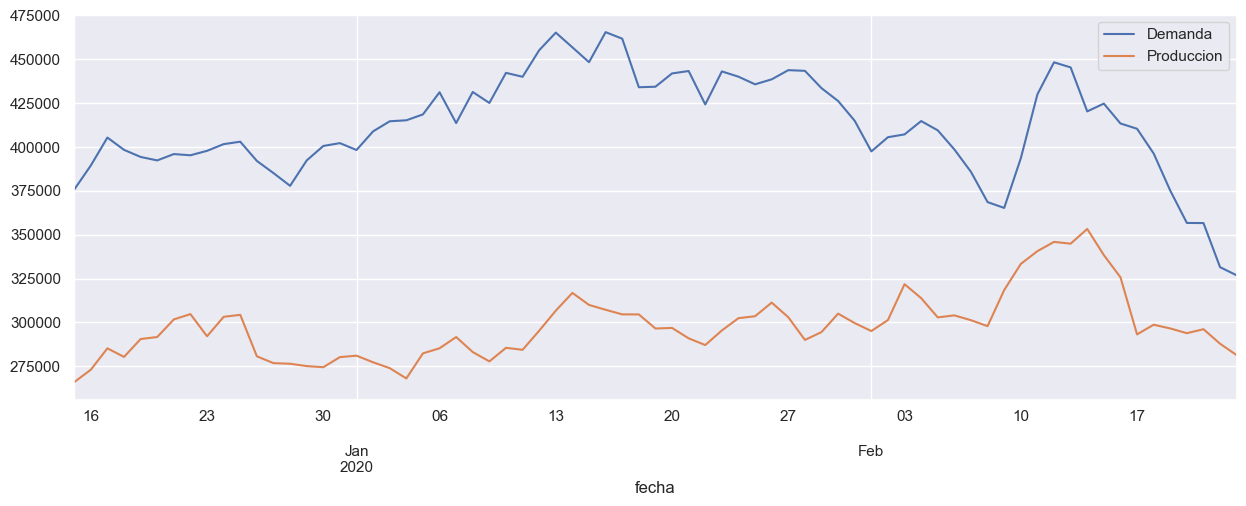

In [59]:
dataPreCovid.plot(figsize=(15,5))

In [60]:
dataCovid = data[data.index <= pd.to_datetime("30-04-2020")].copy()
dataCovid = dataCovid[pd.to_datetime("24-02-2020") <= dataCovid.index ]
dataCovid

Demanda  Produccion
fecha                          
2020-02-24   314394      274931
2020-02-25   308539      261047
2020-02-26   313477      282819
2020-02-27   338249      294075
2020-02-28   332861      286547
...             ...         ...
2020-04-26   371136      325099
2020-04-27   344921      304380
2020-04-28   325709      300122
2020-04-29   325771      259414
2020-04-30   316859      274876

[67 rows x 2 columns]

<AxesSubplot:xlabel='fecha'>

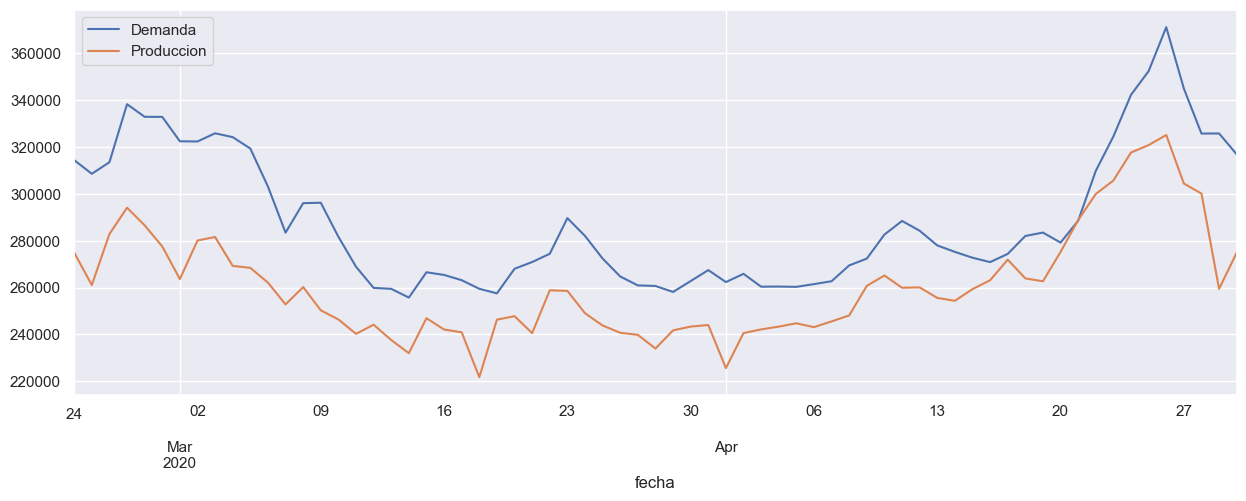

In [61]:
dataCovid.plot(figsize=(15,5))

In [62]:
media_Covid_precovid = pd.DataFrame() 
datosCovid = {'Periodo': ['Pre-Covid','Covid principio'],
        'Media demanda': [dataPreCovid['Demanda'].mean(), dataCovid['Demanda'].mean()],
        'Media produccion': [dataPreCovid['Produccion'].mean(), dataCovid['Produccion'].mean()]}

media_Covid_precovid = pd.DataFrame(datosCovid)
media_Covid_precovid = media_Covid_precovid.set_index('Periodo')
media_Covid_precovid

Media demanda  Media produccion
Periodo                                         
Pre-Covid        412271.957746     297922.295775
Covid principio  288816.000000     261000.223881

Text(0, 0.5, 'Cuantidad')

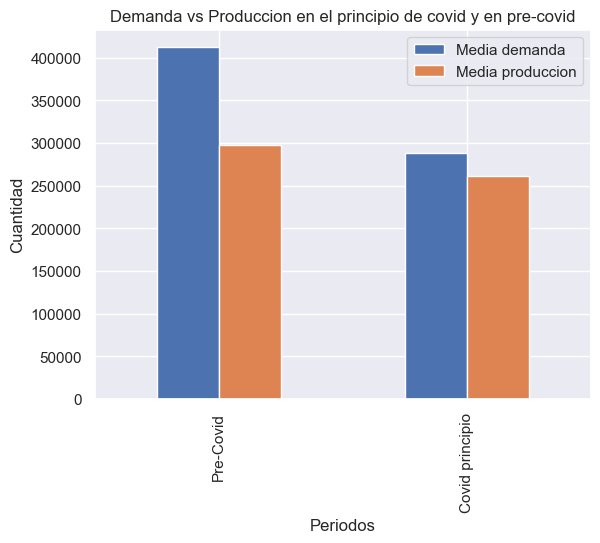

In [63]:
media_Covid_precovid.plot(kind="bar")
plt.title("Demanda vs Produccion en el principio de covid y en pre-covid")
plt.xlabel("Periodos")
plt.ylabel("Cuantidad")

# Festivo nacionales 

In [64]:
# Lista de días festivos
festivos = ["01-jan-2019", "06-jan-2019", "01-may-2019", "14-jul-2019", "03-oct-2019",
            "01-jan-2020", "06-jan-2020", "01-may-2020", "14-jul-2020", "03-oct-2020",
            "01-jan-2021", "06-jan-2021", "01-may-2021", "14-jul-2021", "03-oct-2021"]

# Crear una columna 'Festivo_Nacional' en el DataFrame
data['Festivo_Nacional'] = data.index.isin(festivos).astype(int)



In [65]:
data

Demanda  Produccion  Festivo_Nacional
fecha                                            
2019-01-01   379726      289005                 1
2019-01-02   383590      288843                 0
2019-01-03   378901      283581                 0
2019-01-04   378180      285621                 0
2019-01-05   385805      283991                 0
...             ...         ...               ...
2021-12-26   466243      299610                 0
2021-12-27   435243      291977                 0
2021-12-28   420410      279246                 0
2021-12-29   411592      261122                 0
2021-12-30   378184      248905                 0

[1095 rows x 3 columns]

In [66]:
# Extraer características y etiquetas
features = data[['Demanda']].values
labels = data['Festivo_Nacional'].values

# Escalar las características
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Función para crear conjuntos de datos con pasos temporales para LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 180
X, y = create_dataset(scaled_features, labels, TIME_STEPS)

# Crea una nueva máscara booleana para las fechas que han sido transformadas
mask_train = data.index[TIME_STEPS:].year < 2021
mask_test = (data.index[TIME_STEPS:].year == 2021) & (data['Festivo_Nacional'][TIME_STEPS:] == 1)

# Usa esta nueva máscara para dividir los datos
X_train, y_train = X[mask_train], y[mask_train]
X_test, y_test = X[mask_test], y[mask_test]

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)


Epoch 1/20
18/18 [==============================] - 5s 108ms/step - loss: 0.5735 - accuracy: 0.9873 - val_loss: 1.2513 - val_accuracy: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 1s 74ms/step - loss: 0.1298 - accuracy: 0.9873 - val_loss: 4.8621 - val_accuracy: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 1s 74ms/step - loss: 0.0702 - accuracy: 0.9873 - val_loss: 4.9202 - val_accuracy: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 1s 77ms/step - loss: 0.0695 - accuracy: 0.9873 - val_loss: 4.5726 - val_accuracy: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 1s 75ms/step - loss: 0.0685 - accuracy: 0.9873 - val_loss: 4.4058 - val_accuracy: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 1s 75ms/step - loss: 0.0683 - accuracy: 0.9873 - val_loss: 4.3948 - val_accuracy: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 1s 69ms/step - loss: 0.0682 - accuracy: 0.9873 - val_loss: 4.4159 - val_accur

In [67]:
# Extraer características y etiquetas
features = data[['Produccion','Demanda']].values
labels = data['Festivo_Nacional'].values

# Escalar las características
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Función para crear conjuntos de datos con pasos temporales para LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 180
X, y = create_dataset(scaled_features, labels, TIME_STEPS)

# Crea una nueva máscara booleana para las fechas que han sido transformadas
mask_train = data.index[TIME_STEPS:].year < 2021
mask_test = (data.index[TIME_STEPS:].year == 2021) & (data['Festivo_Nacional'][TIME_STEPS:] == 1)

# Usa esta nueva máscara para dividir los datos
X_train, y_train = X[mask_train], y[mask_train]
X_test, y_test = X[mask_test], y[mask_test]

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)


Epoch 1/20
18/18 [==============================] - 6s 112ms/step - loss: 0.5450 - accuracy: 0.9328 - val_loss: 1.3982 - val_accuracy: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 2s 92ms/step - loss: 0.1311 - accuracy: 0.9873 - val_loss: 3.7056 - val_accuracy: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 2s 89ms/step - loss: 0.0680 - accuracy: 0.9873 - val_loss: 4.4987 - val_accuracy: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 2s 91ms/step - loss: 0.0683 - accuracy: 0.9873 - val_loss: 4.5659 - val_accuracy: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 2s 94ms/step - loss: 0.0684 - accuracy: 0.9873 - val_loss: 4.4728 - val_accuracy: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 2s 91ms/step - loss: 0.0682 - accuracy: 0.9873 - val_loss: 4.4154 - val_accuracy: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 2s 84ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.4016 - val_accur

In [68]:
# Predicciones
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Mostrar resultados
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))



1/1 [==============================] - 0s 427ms/step
Accuracy: 0.00%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       5.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



Como vemos el modelo no consigue acerta ningun dia

In [69]:
Festivos_Nacionales = ["01-jan-2019" ,"06-jan-2019","01-may-2019","14-jul-2019","03-oct-2019","01-jan-2020" ,"06-jan-2020","01-may-2020","14-jul-2020","03-oct-2020","01-jan-2021" ,"06-jan-2021","01-may-2021","14-jul-2021","03-oct-2021"]
Festivos_Nacionales


['01-jan-2019',
 '06-jan-2019',
 '01-may-2019',
 '14-jul-2019',
 '03-oct-2019',
 '01-jan-2020',
 '06-jan-2020',
 '01-may-2020',
 '14-jul-2020',
 '03-oct-2020',
 '01-jan-2021',
 '06-jan-2021',
 '01-may-2021',
 '14-jul-2021',
 '03-oct-2021']

In [70]:
dataFestivo = data[data.index.isin(Festivos_Nacionales)]
dataFestivo


Demanda  Produccion  Festivo_Nacional
fecha                                            
2019-01-01   379726      289005                 1
2019-01-06   378280      278314                 1
2019-05-01   323099      262720                 1
2019-07-14   493512      412650                 1
2019-10-03   461922      375271                 1
2020-01-01   398283      281007                 1
2020-01-06   431218      285232                 1
2020-05-01   320559      299753                 1
2020-07-14   579399      400581                 1
2020-10-03   431841      378241                 1
2021-01-01   398854      249832                 1
2021-01-06   406022      256305                 1
2021-05-01   397250      339273                 1
2021-07-14   608133      439941                 1
2021-10-03   397250      273672                 1

<AxesSubplot:xlabel='fecha'>

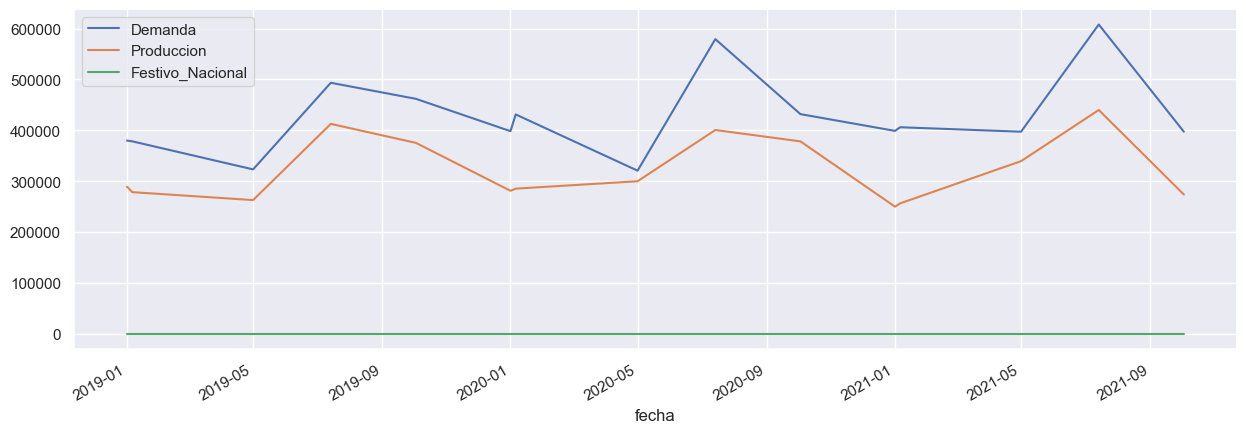

In [71]:
dataFestivo.plot(figsize=(15,5))

Text(0, 0.5, 'Cuantidad')

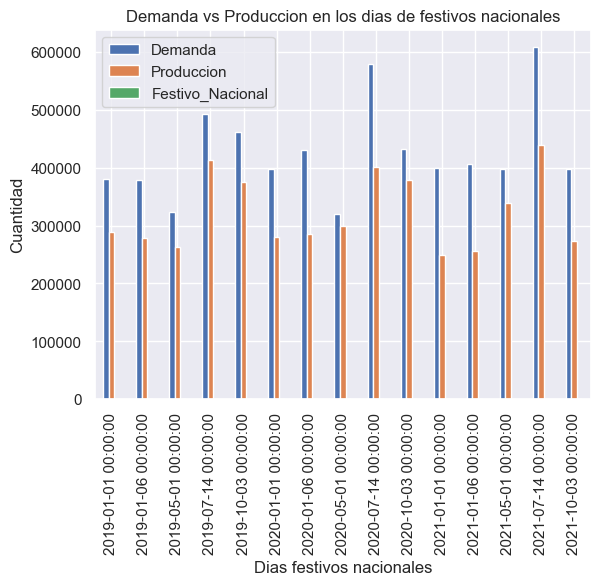

In [72]:
dataFestivo.plot(kind="bar")
plt.title("Demanda vs Produccion en los dias de festivos nacionales")
plt.xlabel("Dias festivos nacionales")
plt.ylabel("Cuantidad")

In [73]:
dataTemporadasProduccion = dataEstacion.groupby('estacion').agg(media_produccion=('Produccion','mean')).reset_index()
dataTemporadasProduccion

estacion  media_produccion
0   Invierno     268142.710383
1      Otoño     283917.808743
2  Primavera     306742.420765
3     Verano     403776.814208

In [74]:
dataTemporadasDemanda = dataEstacion.groupby('estacion').agg(media_Demanda=('Demanda','mean')).reset_index()
dataTemporadasDemanda

estacion  media_Demanda
0   Invierno  368132.762295
1      Otoño  342338.863388
2  Primavera  365714.278689
3     Verano  540844.855191

In [75]:
dataTemporadas = pd.merge(dataTemporadasDemanda, dataTemporadasProduccion, on='estacion')
dataTemporadas = dataTemporadas.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})
dataTemporadas = dataTemporadas.set_index('estacion')
dataTemporadas

media_Demanda  media_produccion
estacion                                  
Invierno   368132.762295     268142.710383
Otoño      342338.863388     283917.808743
Primavera  365714.278689     306742.420765
Verano     540844.855191     403776.814208

Text(0, 0.5, 'Capacidad media')

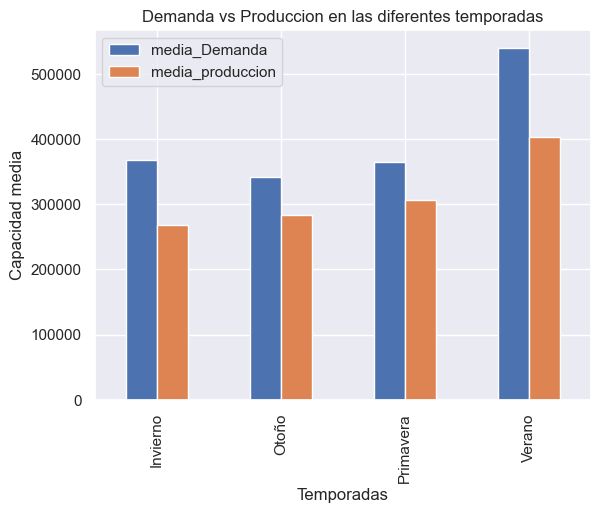

In [76]:
dataTemporadas.plot(kind="bar")
plt.title("Demanda vs Produccion en las diferentes temporadas")
plt.xlabel("Temporadas")
plt.ylabel("Capacidad media")

# Shaaban vs  Ramadan

In [29]:
data_shaaban_ramadan = pd.read_csv("datosFinales.csv")

In [30]:
data_shaaban_ramadan

Demanda  Produccion
0      379726      289005
1      383590      288843
2      378901      283581
3      378180      285621
4      385805      283991
...       ...         ...
1093   411592      261122
1094   378184      248905
1095   414996      257533
1096   437452      272710
1097   417780      277922

[1098 rows x 2 columns]

In [31]:
date_index = pd.date_range(start="01-01-2019", periods=len(data_shaaban_ramadan), freq='D')
data_shaaban_ramadan.index = date_index

In [40]:
data_shaaban_ramadan

Demanda  Produccion  label
2019-01-01   379726      289005      0
2019-01-02   383590      288843      0
2019-01-03   378901      283581      0
2019-01-04   378180      285621      0
2019-01-05   385805      283991      0
...             ...         ...    ...
2021-12-29   411592      261122      0
2021-12-30   378184      248905      0
2021-12-31   414996      257533      0
2022-01-01   437452      272710      0
2022-01-02   417780      277922      0

[1098 rows x 3 columns]

In [33]:
labels = pd.Series(0, index=data_shaaban_ramadan.index)
labels[(pd.to_datetime("06-may-2019") <= labels.index) & (labels.index <= pd.to_datetime("04-jun-2019"))] = 1
labels[(pd.to_datetime("06-apr-2019") <= labels.index) & (labels.index <= pd.to_datetime("05-may-2019"))] = 1
labels[(pd.to_datetime("24-apr-2020") <= labels.index) & (labels.index <= pd.to_datetime("23-may-2020"))] = 1
labels[(pd.to_datetime("25-mar-2020") <= labels.index) & (labels.index <= pd.to_datetime("23-apr-2020"))] = 1
labels[(pd.to_datetime("13-apr-2021") <= labels.index) & (labels.index <= pd.to_datetime("12-may-2021"))] = 1
labels[(pd.to_datetime("14-mar-2021") <= labels.index) & (labels.index <= pd.to_datetime("12-apr-2021"))] = 1
data_shaaban_ramadan['label'] = labels

In [34]:
features = ['Demanda', 'Produccion', 'label']
train_data = data_shaaban_ramadan[features]['2019-01-01':'2020-12-31']
valid_data = data_shaaban_ramadan[features]['2021-01-01':]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)

In [35]:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-1])
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [36]:
look_back = 60
X_train, y_train = create_dataset(train_scaled, look_back)
X_valid, y_valid = create_dataset(valid_scaled, look_back)

In [37]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

Epoch 1/50


21/21 - 8s - loss: 0.5488 - accuracy: 0.7437 - val_loss: 0.4018 - val_accuracy: 0.8046 - 8s/epoch - 363ms/step
Epoch 2/50
21/21 - 2s - loss: 0.4379 - accuracy: 0.8212 - val_loss: 0.3572 - val_accuracy: 0.8046 - 2s/epoch - 74ms/step
Epoch 3/50
21/21 - 2s - loss: 0.3880 - accuracy: 0.8212 - val_loss: 0.3204 - val_accuracy: 0.8046 - 2s/epoch - 88ms/step
Epoch 4/50
21/21 - 1s - loss: 0.3607 - accuracy: 0.8212 - val_loss: 0.2809 - val_accuracy: 0.8046 - 1s/epoch - 63ms/step
Epoch 5/50
21/21 - 2s - loss: 0.3431 - accuracy: 0.8212 - val_loss: 0.3000 - val_accuracy: 0.8046 - 2s/epoch - 73ms/step
Epoch 6/50
21/21 - 2s - loss: 0.3126 - accuracy: 0.8212 - val_loss: 0.4146 - val_accuracy: 0.8046 - 2s/epoch - 72ms/step
Epoch 7/50
21/21 - 1s - loss: 0.3401 - accuracy: 0.8346 - val_loss: 0.2171 - val_accuracy: 0.8046 - 1s/epoch - 59ms/step
Epoch 8/50
21/21 - 1s - loss: 0.3735 - accuracy: 0.7884 - val_loss: 0.2607 - val_accuracy: 0.8893 - 1s/epoch - 64ms/step
Epoch 9/50
21/21 - 1s - loss: 0.3112 - acc

In [38]:
y_pred_probs = model.predict(X_valid)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

10/10 [==============================] - 1s 23ms/step


In [39]:
real_days = y_valid[y_valid == 1]
predicted_days = y_pred[y_valid == 1]

# Calcular y mostrar la precisión
accuracy = accuracy_score(real_days, predicted_days)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Mostrar el informe de clasificación
report = classification_report(real_days, predicted_days)
print(report)

Accuracy: 23.33%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.23      0.38        60

    accuracy                           0.23        60
   macro avg       0.50      0.12      0.19        60
weighted avg       1.00      0.23      0.38        60



In [50]:
#2019
dataRamadan2019 = data[pd.to_datetime("06-may-2019") <= data.index ]
dataRamadan2019  = dataRamadan2019[dataRamadan2019.index <= pd.to_datetime("04-jun-2019")]

dataShaaban2019 = data[pd.to_datetime("06-apr-2019") <= data.index ]
dataShaaban2019  = dataShaaban2019[dataShaaban2019.index <= pd.to_datetime("05-may-2019")]

#2020
dataRamadan2020 = data[pd.to_datetime("24-apr-2020") <= data.index ]
dataRamadan2020  = dataRamadan2020[dataRamadan2020.index <= pd.to_datetime("23-may-2020")]

dataShaaban2020 = data[pd.to_datetime("25-mar-2020") <= data.index ]
dataShaaban2020  = dataShaaban2020[dataShaaban2020.index <= pd.to_datetime("23-apr-2020")]

#2021
dataRamadan2021 = data[pd.to_datetime("13-apr-2021") <= data.index ]
dataRamadan2021  = dataRamadan2021[dataRamadan2021.index <= pd.to_datetime("12-may-2021")]

dataShaaban2021 = data[pd.to_datetime("14-mar-2021") <= data.index ]
dataShaaban2021  = dataShaaban2021[dataShaaban2021.index <= pd.to_datetime("12-apr-2021")]


In [51]:
media_Chaaban_Ramadan = pd.DataFrame() 
datos = {'Mes_hijri': ['Shaaban 2019','Ramadan 2019' ,'Shaaban 2020','Ramadan 2020', 'Shaaban 2021','Ramadan 2021'],
        'Media demanda': [dataShaaban2019['Demanda'].mean(), dataRamadan2019['Demanda'].mean(), dataShaaban2020['Demanda'].mean(), dataRamadan2020['Demanda'].mean(), dataShaaban2021['Demanda'].mean(),dataRamadan2021['Demanda'].mean()],
        'Media produccion': [dataShaaban2019['Produccion'].mean(), dataRamadan2019['Produccion'].mean(), dataShaaban2020['Produccion'].mean(), dataRamadan2020['Produccion'].mean(), dataShaaban2021['Produccion'].mean(),dataRamadan2021['Produccion'].mean()]}

media_Shaaban_Ramadan = pd.DataFrame(datos)
media_Shaaban_Ramadan = media_Shaaban_Ramadan.set_index('Mes_hijri')
media_Shaaban_Ramadan

Media demanda  Media produccion
Mes_hijri                                    
Shaaban 2019  286469.000000     238806.866667
Ramadan 2019  395727.033333     357752.066667
Shaaban 2020  273865.533333     255552.966667
Ramadan 2020  386320.000000     335347.600000
Shaaban 2021  288550.200000     240607.533333
Ramadan 2021  400432.066667     314738.500000

Text(0, 0.5, 'Media')

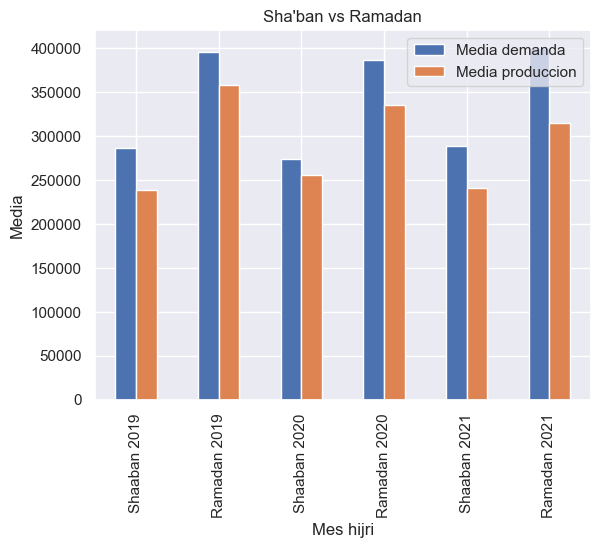

In [52]:
media_Shaaban_Ramadan.plot(kind="bar")
plt.title("Sha'ban vs Ramadan")
plt.xlabel("Mes hijri")
plt.ylabel("Media")

In [53]:
data.describe()

Demanda     Produccion
count    1095.000000    1095.000000
mean   420994.799087  322561.829224
std    108713.245473   69567.326734
min    234522.000000  187266.000000
25%    325740.000000  258997.500000
50%    411592.000000  303169.000000
75%    498163.500000  391964.000000
max    664606.000000  453020.000000

Ya de primera podemos observar que vamos a tener dias donde la demanda supera a la produccion, y ademas de media siempre vamos a tener mayor demanda que produccion

In [76]:
dataMes= data.resample('m').sum()
dataMes

Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12639971     8785986
2022-01-31    855232      550632

In [55]:
dataAno = data.resample('y').sum()
dataAno

Demanda  Produccion
fecha                            
2019-12-31  143314874   116508462
2020-12-31  152389040   117898414
2021-12-31  165285391   118798327

<AxesSubplot:xlabel='fecha'>

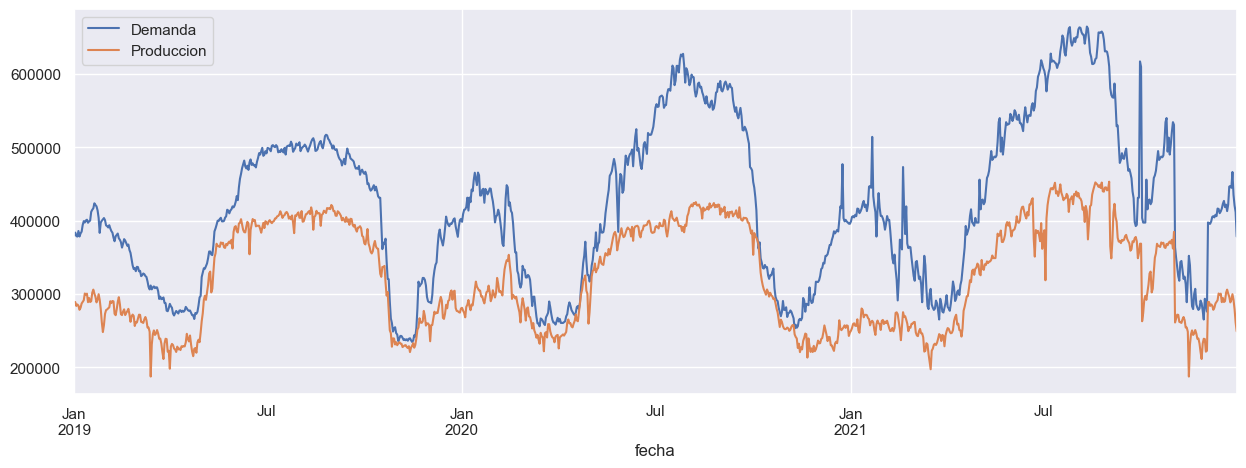

In [56]:
data.plot(figsize=(15,5))

<AxesSubplot:>

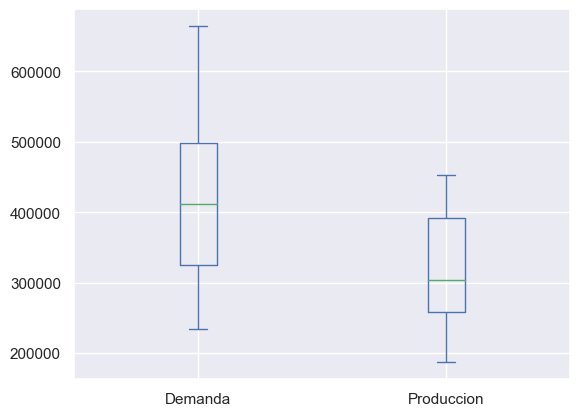

In [57]:
data.plot.box()

Vemos que la produccion nunca abaste la demanda, ademas nos fijamos que en los meses de verano siempre tenemos un pico de demanda que ademas aumenta con los años mientras que la produccion de mantiene

# Dickey-fuller

Vamos a pasar a comprobar si nuestra serie de tiempo es estacionario o no. Para ello vamos a seguir el modelo Dickey-Fuller

In [58]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviacion estandar')
    plt.legend(loc='best')
    plt.title('Media móvil & Desviacion estandar')
    plt.show(block=False)
    
    print ('Resultados del Dickey-Fuller Test:')
   
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba','p-value','#Lags Used','Numero de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valores criticos (%s)'%key] = value
    print(dfoutput)

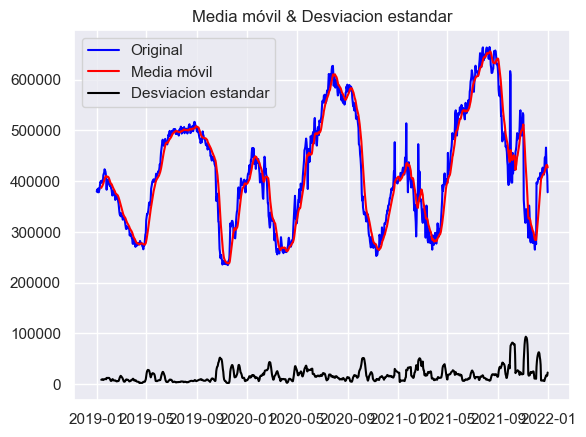

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -3.080073
p-value                       0.028063
#Lags Used                   16.000000
Numero de observaciones    1078.000000
Valores criticos (1%)        -3.436431
Valores criticos (5%)        -2.864225
Valores criticos (10%)       -2.568200
dtype: float64


In [59]:
adfullerDemanda = test_stationarity(data['Demanda'])

Según estos resultados vemos observamos que podemos afirmar que al demanda es estacionario por diversos motivos, el p-value nos indica que tenemos una probabilidad muy baja del 2.68% de que los resultados observados en la serie de tiempo se deban al azar que nos indica que podemos rechazar la hipotesis nula. Luego el estadístico de prueba es menor que los valores críticos para los niveles de significación de 1% y 5% y no difiere mucho del 10% por lo que volvemos a rechazar la hipotesis nula. 

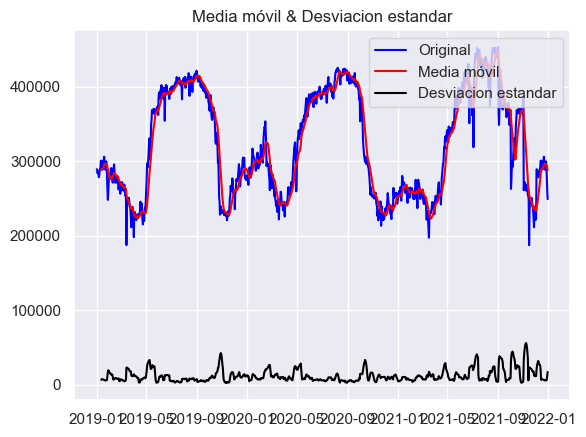

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -2.022303
p-value                       0.276880
#Lags Used                    4.000000
Numero de observaciones    1090.000000
Valores criticos (1%)        -3.436364
Valores criticos (5%)        -2.864195
Valores criticos (10%)       -2.568184
dtype: float64


In [60]:
adfullerProduccion = test_stationarity(data['Produccion'])

Con la produccion vemos que ocurre todo lo contrario, el p-value es mayor que el valor de significancia del 0,05 y ademas nuestro estadistico de prueba es mayor que todos los valores criticos. Por lo cual decidimos que la serie de tiempo no es estacionaria.

## ARIMA

Sabiendo que la demanda si es estacionaria, vamos a aplicarle un modelo de  regresion autorregresiva integrada de media movil (ARIMA)

In [61]:
dataArima= dataMes['Demanda'].copy()


In [62]:
train_data_arima = dataArima[:int(len(dataArima)*0.8)].copy()
test_data_arima = dataArima[int(len(dataArima)*0.8):].copy()


In [63]:
def modelo_arima(p,d,q):
    model = ARIMA(train_data_arima, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())

In [64]:
modelo_arima(1,1,1)
modelo_arima(2,1,1)
modelo_arima(2,1,2)


                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.052
Date:                Thu, 24 Aug 2023   AIC                            878.104
Time:                        18:38:49   BIC                            881.991
Sample:                    01-31-2019   HQIC                           879.260
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      1.231     -0.177      0.860      -2.631       2.196
ma.L1          0.3382      1.249      0.271      0.787      -2.109       2.786
sigma2      5.968e+12   4.28e-13   1.39e+25      0.0

Vamos a probar con una funcion que nos saca lo mejores valores

Vemos que el mejor AIC lo tiene el modelo para los valores (2,1,2)

In [65]:
modelfinal = ARIMA(train_data_arima, order=(2, 1, 2))
model_fit1 = modelfinal.fit()

In [66]:
forecast = model_fit1.forecast(steps=10)[0]

In [67]:
print(forecast)

11083109.210077316


In [68]:
predicciones = model_fit1.predict(start=len(train_data_arima), end=len(dataArima)-1, typ='levels')
predicciones

2021-05-31    1.108311e+07
2021-06-30    1.302891e+07
2021-07-31    1.414135e+07
2021-08-31    1.331579e+07
2021-09-30    1.140824e+07
2021-10-31    1.034849e+07
2021-11-30    1.118810e+07
2021-12-31    1.305750e+07
Freq: M, Name: predicted_mean, dtype: float64

In [69]:
errorARIMA = np.mean(np.abs((test_data_arima - predicciones) / test_data_arima)) * 100
accuracyARIMA = 100 - errorARIMA
mseARIMA = mean_squared_error(test_data_arima, predicciones)

In [70]:
print(f"Precision modelo ARIMA es: {accuracyARIMA}" )
print(f"El error es: {errorARIMA}")
print(f"El error cuadrático mse: {mseARIMA} kw")

Precision modelo ARIMA es: 76.83425210441922
El error es: 23.16574789558078
El error cuadrático mse: 16757269390052.26 kw


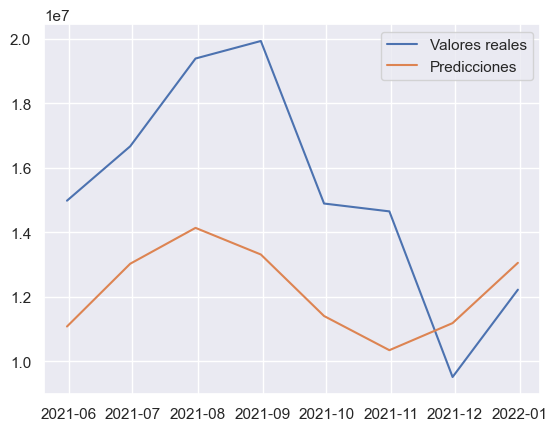

In [71]:
plt.plot(dataArima.index[int(len(dataArima)*0.8):], test_data_arima, label='Valores reales')
plt.plot(dataArima.index[int(len(dataArima)*0.8):], predicciones, label='Predicciones')
plt.legend()
plt.show()

# RNN por días 

Estudiando un poco la relación que existe entre la demanda y la produccion encontramos que esta última siempre va a estar condicionada por la demanda ya que no se puede dar el caso de que la produccion sea mayor que la demanda. Vamos a aplicar un modelo de Deep learning conocido como Redes neuronales recurrentes(RNN), las cuales cuentan con "memoria". Usaremos de tipo LSTM, con dos capas LSTM de 50 unidades, una Dense con una única salida y el optimizador Adam, que para este tipo de series temporales es el mas adecuado

In [71]:
dataRNNdias = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdias), freq='D')
dataRNNdias.index = date_index

In [72]:

def LSTMDemandaDiarioDosCaracteristicas(time_steps, data):
    # Seleccionar las columnas de interés
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    
    # Dividir los datos en entrenamiento y validación
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]
    
    # Escalar los datos
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    # Preparar los datos para LSTM
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # Visualizar el desempeño del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Comparar las predicciones con los valores reales de 2021
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    # Tabla comparativa
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    # Calcular precisión basada en un umbral
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    # Visualizar las predicciones frente a los valores reales
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el día anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 7s 125ms/step - loss: 0.2271 - val_loss: 0.3253
Epoch 2/50
23/23 [==============================] - 0s 10ms/step - loss: 0.1663 - val_loss: 0.2235
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0869 - val_loss: 0.0840
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0174
Epoch 5/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0182
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 8/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0076
Epoch 9/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 11/50
23

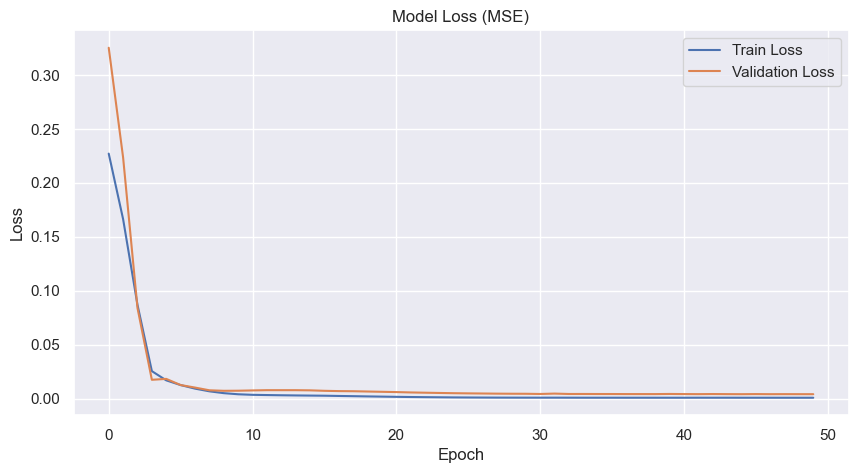

12/12 [==============================] - 1s 2ms/step
     Real Values   Predictions
0         405037  398130.65625
1         406001  403653.28125
2         404353  404733.78125
3         407859  403331.56250
4         406022  406262.40625
..           ...           ...
361       411592  418329.15625
362       378184  409725.40625
363       414996  380530.59375
364       437452  412569.12500
365       417780  431861.53125

[366 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 23.22%


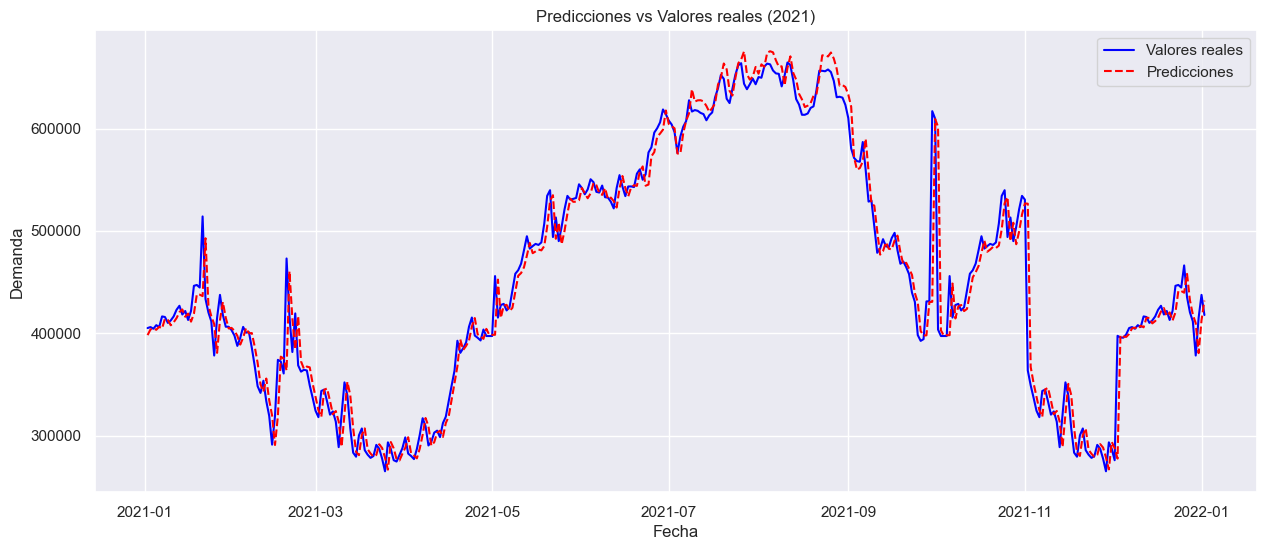

In [73]:
LSTMDemandaDiarioDosCaracteristicas(1, dataRNNdias)

    Cogiendo la semana anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 5s 38ms/step - loss: 0.1402 - val_loss: 0.0264
Epoch 2/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0146 - val_loss: 0.0212
Epoch 3/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0075 - val_loss: 0.0107
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0113
Epoch 5/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0102
Epoch 6/50
23/23 [==============================] - 0s 14ms/step - loss: 0.0037 - val_loss: 0.0096
Epoch 7/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0093
Epoch 8/50
23/23 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0089
Epoch 9/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0088
Epoch 10/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0030 - val_loss: 0.0087
Epoch 11/

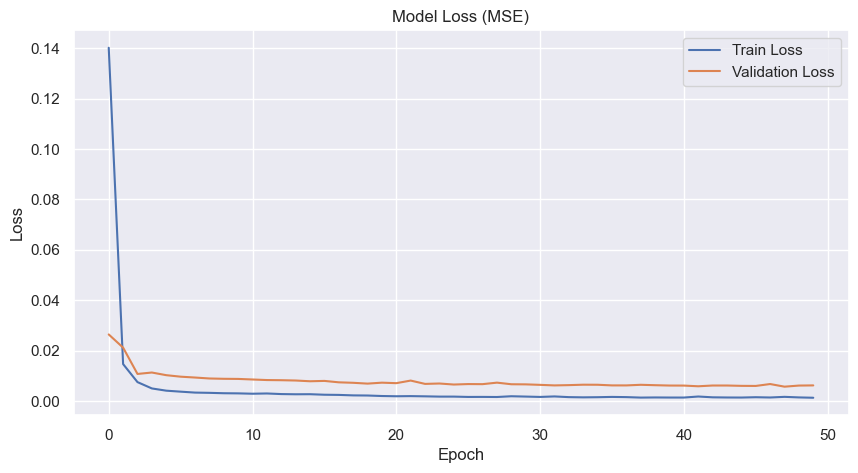

12/12 [==============================] - 0s 5ms/step
     Real Values   Predictions
0         415824  418505.09375
1         410048  419452.50000
2         412486  416404.21875
3         416401  418783.50000
4         422912  426960.43750
..           ...           ...
355       411592  436973.84375
356       378184  422814.40625
357       414996  398917.53125
358       437452  391804.84375
359       417780  409439.59375

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 21.39%


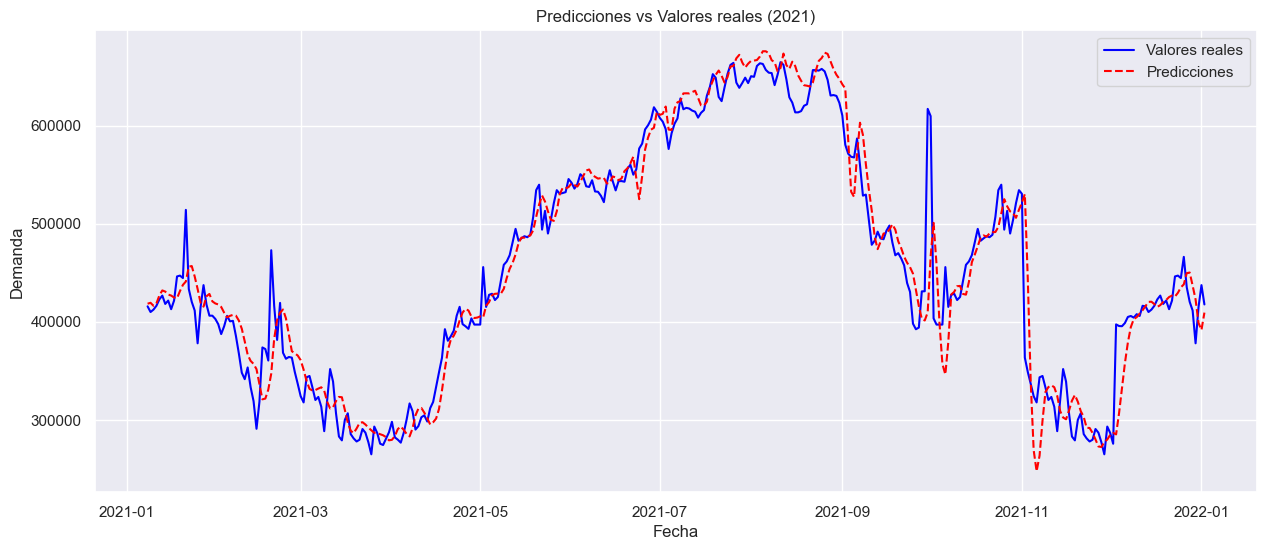

In [74]:
LSTMDemandaDiarioDosCaracteristicas(7, dataRNNdias)

    Cogiendo x tiempo anterior anterior para la prediccion

In [ ]:
LSTMDemandaDiarioDosCaracteristicas(1, dataRNNdias)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataRNNdias['Demanda'] = scaler.fit_transform(dataRNNdias[['Demanda']])
dataRNNdias['Produccion'] = scaler.fit_transform(dataRNNdias[['Produccion']])
timesteps = 30

In [39]:
x = []
y = []
for i in range(timesteps, len(dataRNNdias)):
    x.append(dataRNNdias[i-timesteps:i][['Demanda', 'Produccion']].values)
    y.append(dataRNNdias['Produccion'][i])

In [40]:
x = np.array(x)
y = np.array(y)

In [41]:
train_size = int(len(dataRNNdias) * 0.7)
x_train = x[:train_size, :, :]
y_train = y[:train_size]
x_test = x[train_size:, :, :]
y_test = y[train_size:]

In [42]:
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
modelo.add(LSTM(50))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

In [43]:
modelo.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [44]:
y_pred = modelo.predict(x_test)

10/10 [==============================] - 1s 23ms/step


In [45]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [46]:
y_pred

array([[246364.44],
       [243348.05],
       [242178.25],
       [232627.47],
       [228214.1 ],
       [230050.03],
       [228852.08],
       [221733.84],
       [215640.45],
       [207981.83],
       [216218.94],
       [221142.64],
       [225869.52],
       [228608.62],
       [229244.28],
       [230533.55],
       [233325.2 ],
       [237383.25],
       [240685.73],
       [236970.81],
       [239586.67],
       [240478.64],
       [233928.11],
       [240339.  ],
       [247155.75],
       [250937.69],
       [251674.34],
       [249454.64],
       [248498.58],
       [249722.1 ],
       [253405.78],
       [260803.55],
       [265137.28],
       [268999.72],
       [262955.97],
       [261589.92],
       [255732.  ],
       [254794.22],
       [250103.39],
       [255964.88],
       [273261.16],
       [282755.16],
       [291016.94],
       [294940.56],
       [295885.3 ],
       [303158.38],
       [314351.2 ],
       [316059.7 ],
       [325584.03],
       [329690.3 ],


In [47]:
errorRNND = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNND  = 100 - errorRNND 
mseRNND  = np.mean((y_pred - y_test)**2)

In [48]:
print(f"Precision de la RNN por días es: {accuracyRNND}" )
print(f"El error es: {errorRNND}")
print(f"El error cuadrático mse: {mseRNND} kw")

Precision de la RNN por días es: 96.76649888053095
El error es: 3.233501119469047
El error cuadrático mse: 304956144.0130192 kw


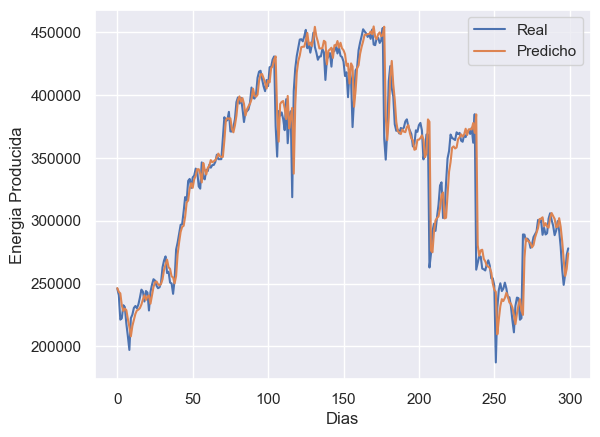

In [49]:
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Dias')
plt.ylabel('Energia Producida')
plt.legend()
plt.show()

## RNN por mes 

Ahora repetimos el proceso pero con algunos cambios y la frecuencia por meses

In [78]:
dataMes= data.resample('m').sum()
dataMes

Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12639971     8785986
2022-01-31    855232      550632

In [79]:
def LSTMDemandaMensualDosCaracteristicas(time_steps, data):
    # Seleccionar las columnas de interés
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    
    # Dividir los datos en entrenamiento y validación
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]
    
    # Escalar los datos
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    # Preparar los datos para LSTM
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # Visualizar el desempeño del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Comparar las predicciones con los valores reales de 2021
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    # Tabla comparativa
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    # Calcular precisión basada en un umbral
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    # Visualizar las predicciones frente a los valores reales
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()


    Cogiendo 1 mes anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.2657 - val_loss: 0.4520
Epoch 2/50
1/1 [==============================] - 0s 49ms/step - loss: 0.2633 - val_loss: 0.4492
Epoch 3/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2609 - val_loss: 0.4463
Epoch 4/50
1/1 [==============================] - 0s 57ms/step - loss: 0.2585 - val_loss: 0.4435
Epoch 5/50
1/1 [==============================] - 0s 88ms/step - loss: 0.2561 - val_loss: 0.4405
Epoch 6/50
1/1 [==============================] - 0s 49ms/step - loss: 0.2535 - val_loss: 0.4375
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2510 - val_loss: 0.4345
Epoch 8/50
1/1 [==============================] - 0s 74ms/step - loss: 0.2484 - val_loss: 0.4314
Epoch 9/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2459 - val_loss: 0.4283
Epoch 10/50
1/1 [==============================] - 0s 51ms/step - loss: 0.2432 - val_loss: 0.4251
Epoch 11/50
1/1 [==============

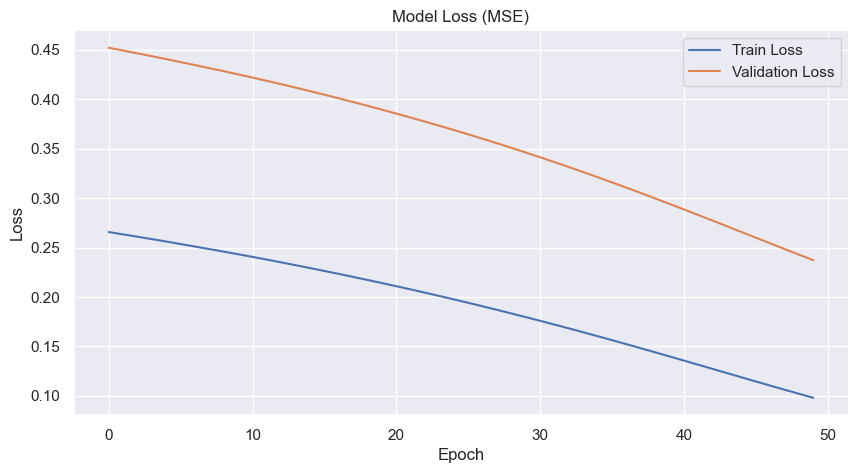

1/1 [==============================] - 1s 603ms/step
    Real Values  Predictions
0      10390139   10323623.0
1       9342708    9944736.0
2      10272893    9867126.0
3      14984538   10144155.0
4      16670675   11132736.0
5      19392643   11480294.0
6      19935514   12104497.0
7      14896197   12209851.0
8      14652679   11156576.0
9       9516929   10973910.0
10     12639971    9920247.0
11       855232   10420469.0
Accuracy basado en un umbral del 1.0%: 8.33%


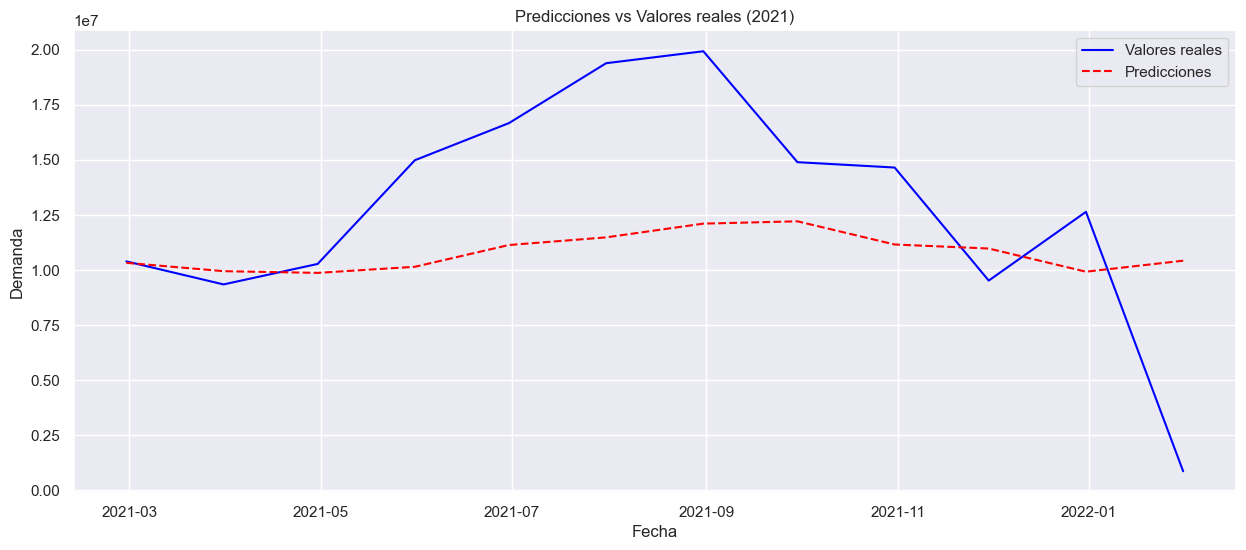

In [80]:
LSTMDemandaMensualDosCaracteristicas(1, dataMes)

    Cogiendo 6 meses anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.3196 - val_loss: 0.5931
Epoch 2/50
1/1 [==============================] - 0s 66ms/step - loss: 0.3086 - val_loss: 0.5808
Epoch 3/50
1/1 [==============================] - 0s 70ms/step - loss: 0.2984 - val_loss: 0.5692
Epoch 4/50
1/1 [==============================] - 0s 74ms/step - loss: 0.2888 - val_loss: 0.5588
Epoch 5/50
1/1 [==============================] - 0s 65ms/step - loss: 0.2800 - val_loss: 0.5494
Epoch 6/50
1/1 [==============================] - 0s 77ms/step - loss: 0.2718 - val_loss: 0.5402
Epoch 7/50
1/1 [==============================] - 0s 74ms/step - loss: 0.2637 - val_loss: 0.5308
Epoch 8/50
1/1 [==============================] - 0s 60ms/step - loss: 0.2557 - val_loss: 0.5214
Epoch 9/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2478 - val_loss: 0.5121
Epoch 10/50
1/1 [==============================] - 0s 67ms/step - loss: 0.2397 - val_loss: 0.5028
Epoch 11/50
1/1 [==============

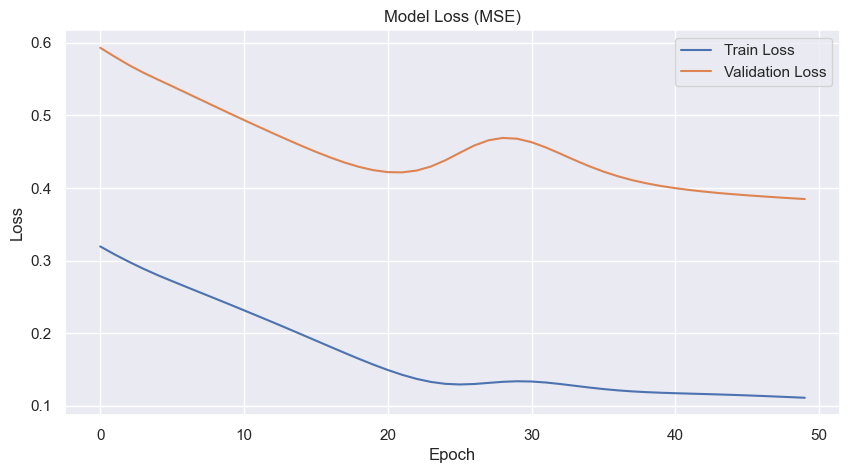

1/1 [==============================] - 0s 330ms/step
   Real Values  Predictions
0     19392643   12002501.0
1     19935514   12253275.0
2     14896197   12692386.0
3     14652679   13073519.0
4      9516929   13334597.0
5     12639971   13206424.0
6       855232   12983468.0
Accuracy basado en un umbral del 1.0%: 0.00%


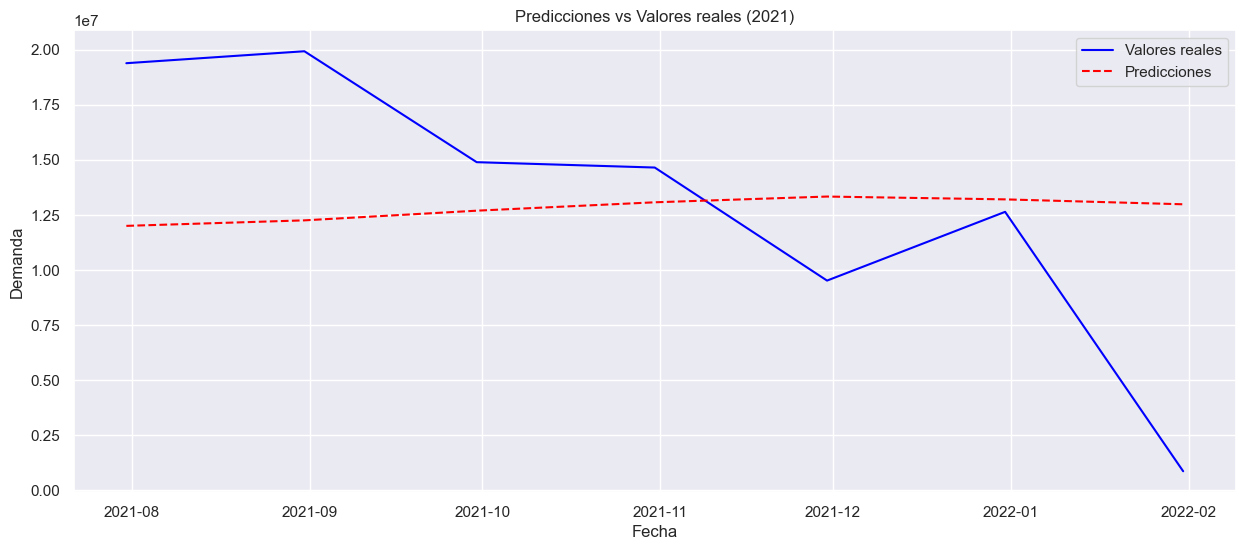

In [83]:
LSTMDemandaMensualDosCaracteristicas(6, dataMes)

In [86]:
X = dataMes.drop("Demanda", axis=1)
y = dataMes["Demanda"]

In [87]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
X_train = X_train.reshape(-1, 1, X_train.shape[1])
X_test = X_test.reshape(-1, 1, X_test.shape[1])

In [90]:
modelo = Sequential()
modelo.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

In [91]:
modelo.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [92]:
train_loss = modelo.evaluate(X_train, y_train, verbose=0)
test_loss = modelo.evaluate(X_test, y_test, verbose=0)
print("Perdidas entreno:", train_loss)
print("Perdidas test :", test_loss)

Perdidas entreno: 0.07498420029878616
Perdidas test : 0.11989085376262665


In [93]:
y_pred = modelo.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [94]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

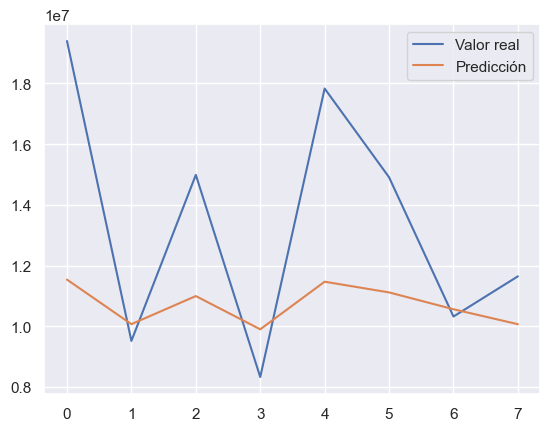

In [95]:
plt.plot(y_test, label='Valor real')
plt.plot(y_pred, label='Predicción')
plt.legend()
plt.show()

In [96]:
errorRNNM = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNNM = 100 - errorRNNM
mseRNNM = np.mean((y_pred - y_test)**2)

In [97]:
print(f"Precision de la RNN por meses es: {accuracyRNNM}" )
print(f"El error es: {errorRNNM}")
print(f"El error cuadrático mse: {mseRNNM} kw")

Precision de la RNN por meses es: 78.90303774561079
El error es: 21.09696225438922
El error cuadrático mse: 17222930097611.746 kw


## RNN por horas para predecir la demanda con dos caracteristicas

In [57]:
dataHoraDemandaLSTM = pd.read_csv("datosHorarios.csv")

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemandaLSTM), freq='H')
dataHoraDemandaLSTM.index = date_hour_index

In [58]:
dataHoraDemandaLSTM

Produccion  Hours  Demanda
2019-01-01 00:00:00       10494      1    11479
2019-01-01 01:00:00        9914      2    10595
2019-01-01 02:00:00        9452      3    10132
2019-01-01 03:00:00        9334      4    10437
2019-01-01 04:00:00        9832      5    11576
...                         ...    ...      ...
2022-01-02 19:00:00       12754     20    19725
2022-01-02 20:00:00       12639     21    18376
2022-01-02 21:00:00       12320     22    17323
2022-01-02 22:00:00       11802     23    16220
2022-01-02 23:00:00       11000     24    15341

[26352 rows x 3 columns]

In [60]:
def LSTMDemandaHorarioDosCaracteristicas(time_steps, data):
    # Seleccionar las columnas de interés
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    
    # Dividir los datos en entrenamiento y validación
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    
    # Escalar los datos
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    # Preparar los datos para LSTM
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # Visualizar el desempeño del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Comparar las predicciones con los valores reales de 2021
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    # Tabla comparativa
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    # Calcular precisión basada en un umbral
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    # Visualizar las predicciones frente a los valores reales
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()



    Cogiendo la hora anterior para la prediccion

Epoch 1/50
548/548 [==============================] - 6s 5ms/step - loss: 0.0220 - val_loss: 0.0027
Epoch 2/50
548/548 [==============================] - 2s 4ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/50
548/548 [==============================] - 2s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/50
548/548 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/50
548/548 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 6/50
548/548 [==============================] - 2s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/50
548/548 [==============================] - 2s 4ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/50
548/548 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 0.0014

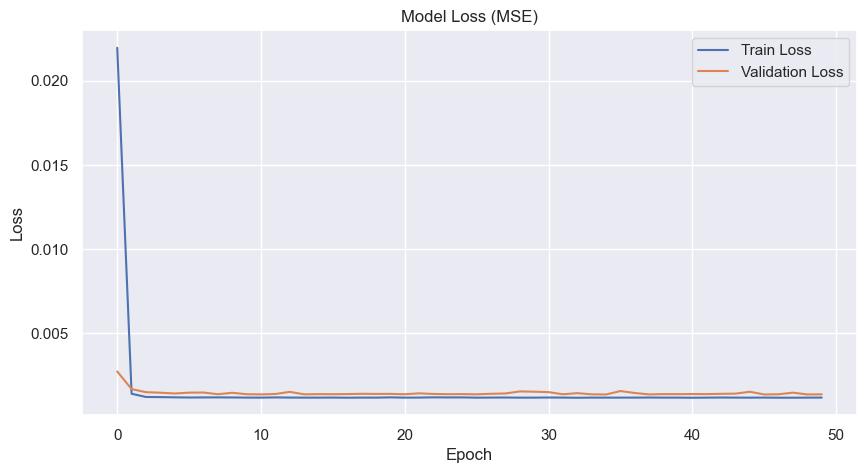

276/276 [==============================] - 1s 2ms/step
      Real Values   Predictions
0           11928  12522.458008
1           11879  11924.051758
2           12429  11874.040039
3           13359  12392.247070
4           14670  13280.213867
...           ...           ...
8801        19725  20868.046875
8802        18376  19651.001953
8803        17323  18276.505859
8804        16220  17212.474609
8805        15341  16104.354492

[8806 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 13.10%


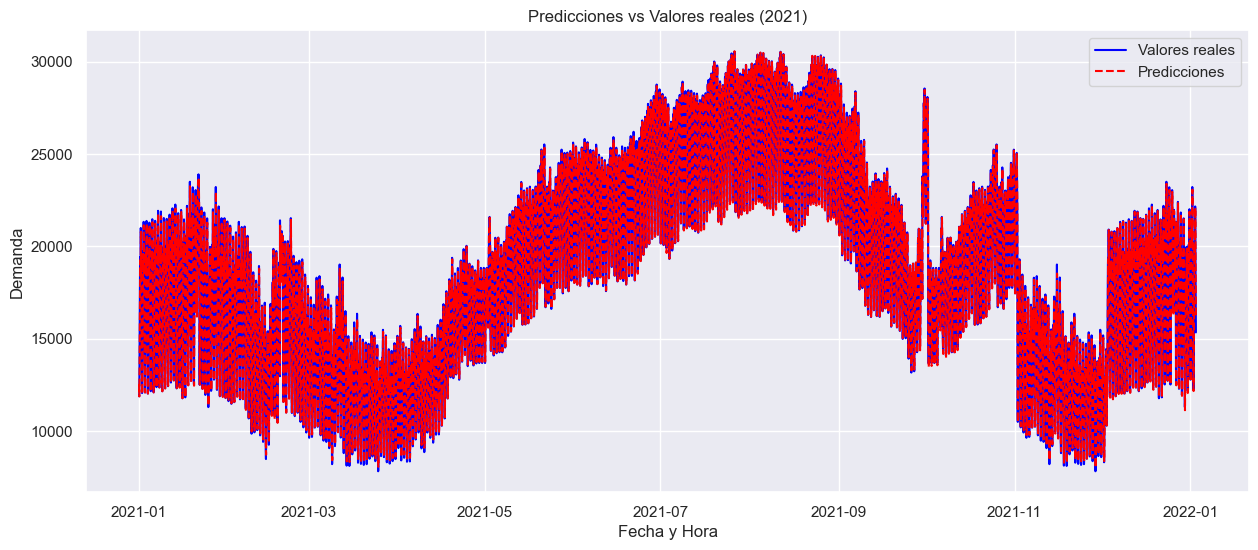

In [61]:
LSTMDemandaHorarioDosCaracteristicas(1, dataHoraDemandaLSTM)

    Cogiendo 24 horas anterior para la prediccion

Epoch 1/50
547/547 [==============================] - 16s 24ms/step - loss: 0.0083 - val_loss: 0.0017
Epoch 2/50
547/547 [==============================] - 12s 22ms/step - loss: 8.3036e-04 - val_loss: 0.0013
Epoch 3/50
547/547 [==============================] - 13s 24ms/step - loss: 5.8952e-04 - val_loss: 0.0012
Epoch 4/50
547/547 [==============================] - 14s 25ms/step - loss: 5.5281e-04 - val_loss: 0.0010
Epoch 5/50
547/547 [==============================] - 12s 22ms/step - loss: 4.4847e-04 - val_loss: 0.0013
Epoch 6/50
547/547 [==============================] - 13s 23ms/step - loss: 4.6887e-04 - val_loss: 7.6544e-04
Epoch 7/50
547/547 [==============================] - 12s 22ms/step - loss: 3.8889e-04 - val_loss: 8.0290e-04
Epoch 8/50
547/547 [==============================] - 18s 33ms/step - loss: 3.7964e-04 - val_loss: 6.9542e-04
Epoch 9/50
547/547 [==============================] - 13s 24ms/step - loss: 3.6241e-04 - val_loss: 6.4829e-04
Epoch 10/50
547/547 [=============

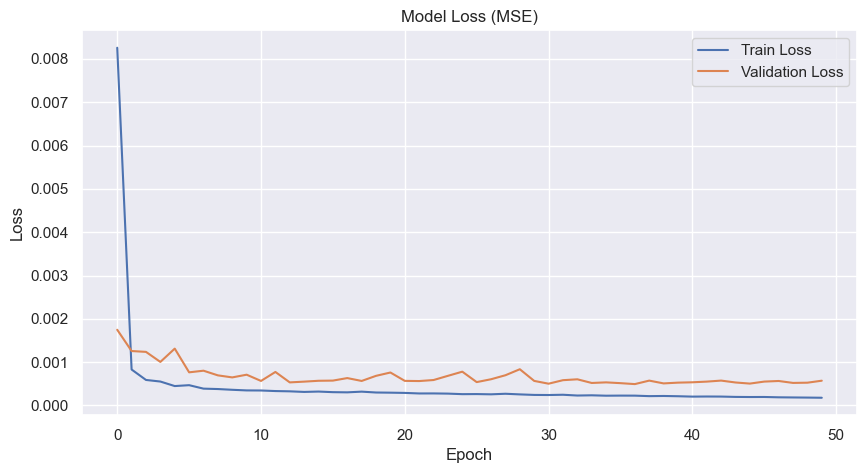

275/275 [==============================] - 3s 10ms/step
      Real Values   Predictions
0           12756  12574.775391
1           12115  11984.442383
2           12053  11704.997070
3           12583  12299.318359
4           13543  13353.315430
...           ...           ...
8778        19725  20167.080078
8779        18376  18698.429688
8780        17323  17492.369141
8781        16220  16354.115234
8782        15341  15029.566406

[8783 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 34.27%


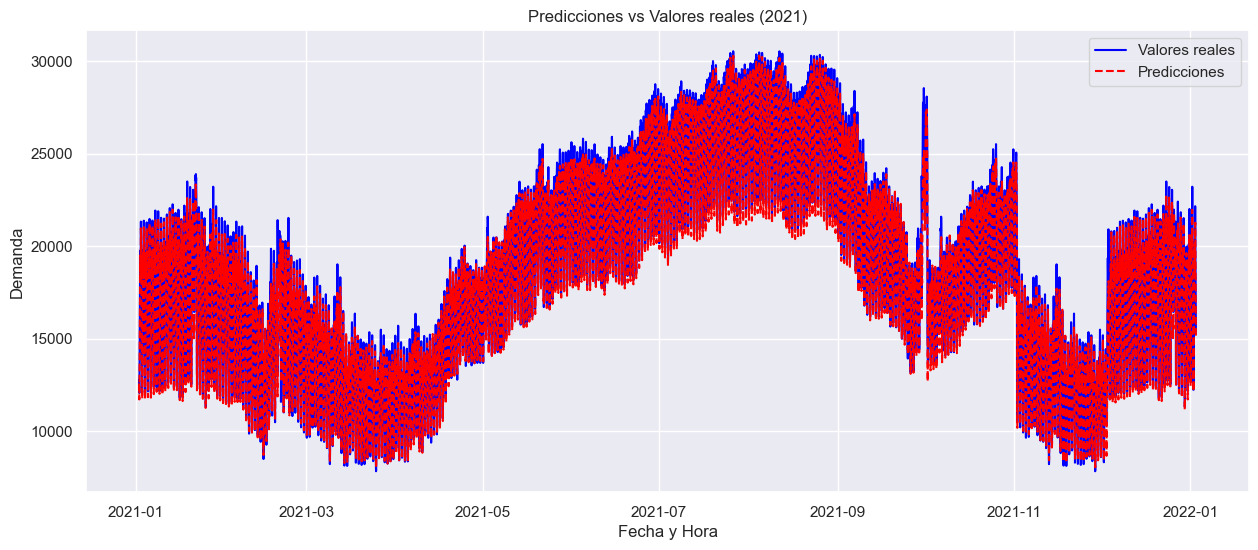

In [62]:
LSTMDemandaHorarioDosCaracteristicas(24, dataHoraDemandaLSTM)

    Cogiendo una semana anterior para la prediccion

In [64]:
LSTMDemandaHorarioDosCaracteristicas(168, dataHoraDemandaLSTM)

Epoch 1/50
264/543 [=============>................] - ETA: 45s - loss: 0.0246

KeyboardInterrupt: 

## RNN por horas para predecir la produccion con dos caracteristicas

In [67]:
dataHoraProduccionLSTM = pd.read_csv("datosHorarios.csv")

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraProduccionLSTM), freq='H')
dataHoraProduccionLSTM.index = date_hour_index

In [68]:
dataHoraProduccionLSTM

Produccion  Hours  Demanda
2019-01-01 00:00:00       10494      1    11479
2019-01-01 01:00:00        9914      2    10595
2019-01-01 02:00:00        9452      3    10132
2019-01-01 03:00:00        9334      4    10437
2019-01-01 04:00:00        9832      5    11576
...                         ...    ...      ...
2022-01-02 19:00:00       12754     20    19725
2022-01-02 20:00:00       12639     21    18376
2022-01-02 21:00:00       12320     22    17323
2022-01-02 22:00:00       11802     23    16220
2022-01-02 23:00:00       11000     24    15341

[26352 rows x 3 columns]

In [69]:


def LSTMProduccionHorarioDosCaracteristicas(time_steps, data):
    # Seleccionar las columnas de interés
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    
    # Dividir los datos en entrenamiento y validación
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    
    # Escalar los datos
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    # Preparar los datos para LSTM
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # Visualizar el desempeño del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Comparar las predicciones con los valores reales de 2021
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    # Tabla comparativa
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    # Calcular precisión basada en un umbral
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    # Visualizar las predicciones frente a los valores reales
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo la hora anterior para la prediccion

Epoch 1/50
548/548 [==============================] - 7s 6ms/step - loss: 0.0434 - val_loss: 0.0015
Epoch 2/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/50
548/548 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 9.7527e-04
Epoch 4/50
548/548 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 9.8531e-04
Epoch 5/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 9.3977e-04
Epoch 8/50
548/548 [==============================] - 3s 5ms/step - loss: 0.0011 - val_loss: 9.6157e-04
Epoch 9/50
548/548 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 9.3339e-04
Epoch 10/50
548/548 [==============================] - 3s 6ms/step - loss: 0.001

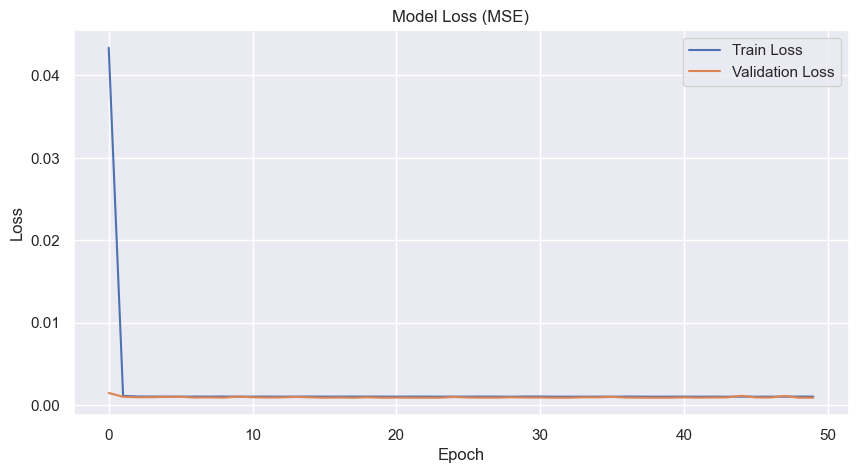

276/276 [==============================] - 1s 3ms/step
      Real Values   Predictions
0            9865  10080.898438
1            9792   9870.043945
2            9938   9798.802734
3           10247   9936.911133
4           10328  10234.966797
...           ...           ...
8801        12754  12813.743164
8802        12639  12716.871094
8803        12320  12584.899414
8804        11802  12258.709961
8805        11000  11746.087891

[8806 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 49.95%


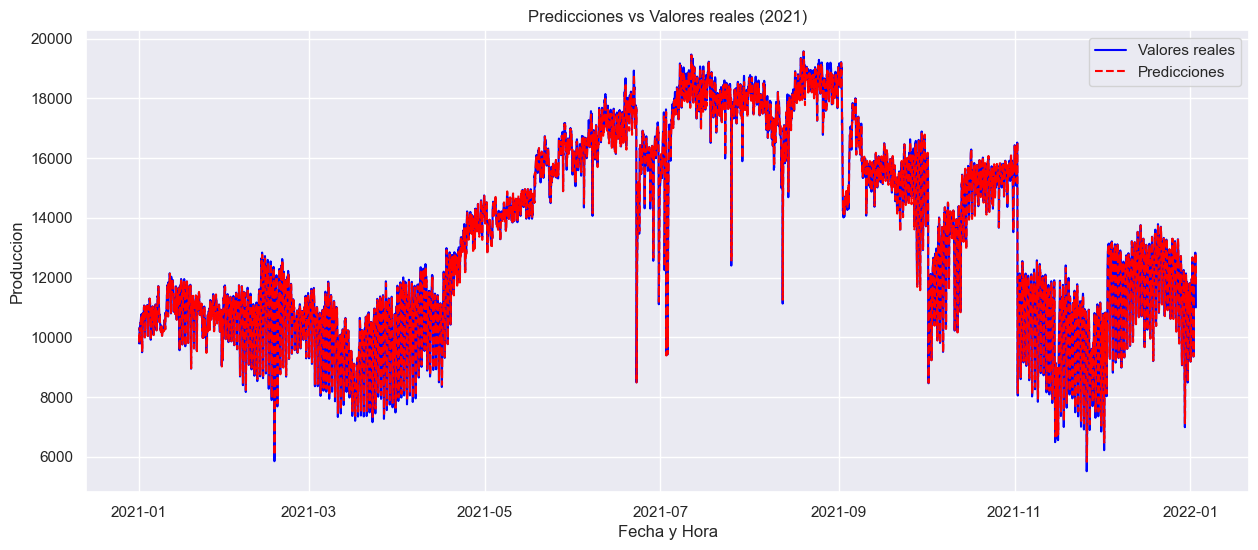

In [70]:
LSTMProduccionHorarioDosCaracteristicas(1, dataHoraProduccionLSTM)

    Cogiendo el dia anterior para la prediccion

In [ ]:
LSTMProduccionHorarioDosCaracteristicas(24, dataHoraProduccionLSTM)

    Cogiendo una semana anterior para la prediccion

In [ ]:
LSTMProduccionHorarioDosCaracteristicas(720, dataHoraProduccionLSTM)

## RNN por días para predecir la demanda solo con la demanda

In [67]:
dataRNNdiasDemanda = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasDemanda), freq='D')
dataRNNdiasDemanda.index = date_index

Epoch 1/50
23/23 [==============================] - 4s 35ms/step - loss: 0.2367 - val_loss: 0.3524
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1976 - val_loss: 0.2904
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.1466 - val_loss: 0.1993
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0815 - val_loss: 0.0863
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0329 - val_loss: 0.0296
Epoch 6/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0252 - val_loss: 0.0251
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 8/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 9/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 11/50
23/2

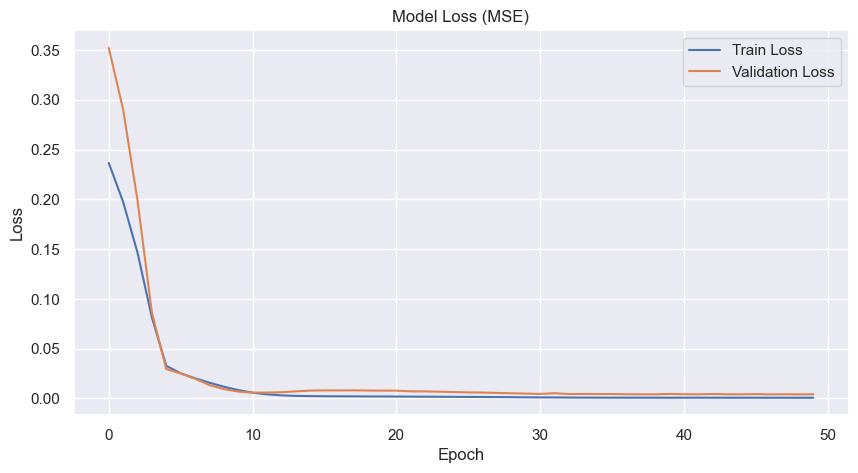

12/12 [==============================] - 0s 3ms/step
     Real Values  Predictions
0       0.396469     0.385824
1       0.398710     0.400796
2       0.394879     0.403146
3       0.403031     0.399132
4       0.398759     0.407660
..           ...          ...
359     0.466702     0.538823
360     0.432213     0.467812
361     0.411710     0.434955
362     0.334032     0.415751
363     0.419625     0.336973

[364 rows x 2 columns]


In [80]:
demand = dataRNNdiasDemanda[['Demanda']]
train_data = demand.loc['2019-01-01':'2020-12-31']
val_data = demand.loc['2021-01-01':'2021-12-31']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Visualizar el desempeño del entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Comparar las predicciones con los valores reales de 2021
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[1:].values, 'Predictions': predictions})

print(comparison)



In [87]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
threshold = 0.01
correct_predictions = np.abs(predictions - val_data['Demanda'].iloc[1:].values) <= threshold * val_data['Demanda'].iloc[1:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

 1/12 [=>............................] - ETA: 0s

12/12 [==============================] - 0s 4ms/step
Accuracy basado en un umbral del 1.0%: 14.01%


12/12 [==============================] - 0s 3ms/step


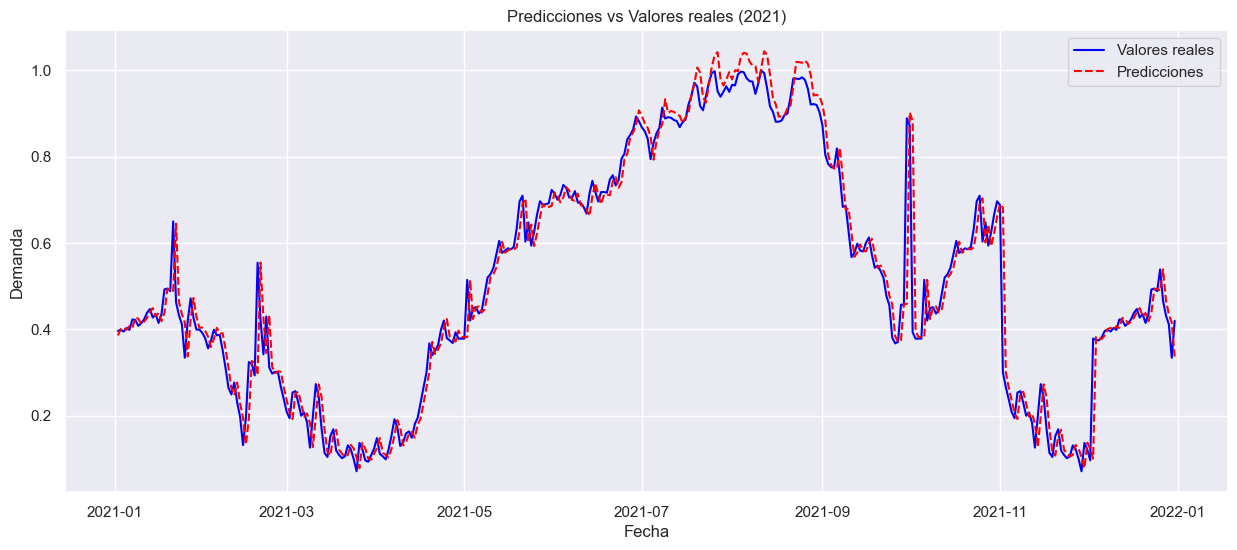

In [83]:

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Demanda'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()

## RNN por días para predecir la produccion solo con la produccion

In [88]:
dataRNNdiasProduccion = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasProduccion), freq='D')
dataRNNdiasProduccion.index = date_index

Epoch 1/50
23/23 [==============================] - 6s 27ms/step - loss: 0.3760 - val_loss: 0.3869
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.3223 - val_loss: 0.3216
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.2529 - val_loss: 0.2339
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.1618 - val_loss: 0.1241
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0666 - val_loss: 0.0399
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0283 - val_loss: 0.0283
Epoch 7/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0245 - val_loss: 0.0248
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.0212
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 11/50
23/23 

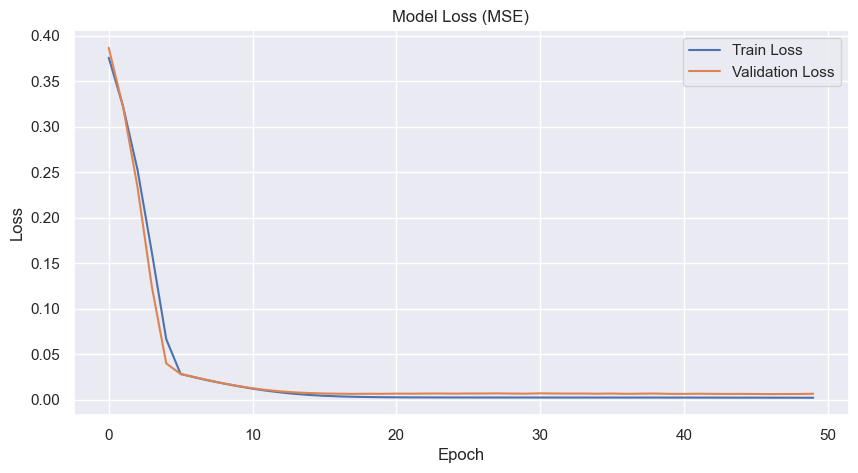

In [89]:
produccion = dataRNNdiasDemanda[['Produccion']]
train_data = produccion.loc['2019-01-01':'2020-12-31']
val_data = produccion.loc['2021-01-01':'2021-12-31']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Visualizar el desempeño del entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [90]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[1:].values, 'Predictions': predictions})

print(comparison)

12/12 [==============================] - 1s 3ms/step
     Real Values    Predictions
0         253488  254220.393550
1         258897  256731.598157
2         259925  260541.469198
3         256563  261278.494002
4         256305  258883.521428
..           ...            ...
359       291977  293112.443942
360       279246  286453.406326
361       261122  275929.990420
362       248905  262141.974493
363       257533  253591.738064

[364 rows x 2 columns]


In [91]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
threshold = 0.01
correct_predictions = np.abs(predictions - val_data['Produccion'].iloc[1:].values) <= threshold * val_data['Produccion'].iloc[1:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

12/12 [==============================] - 0s 3ms/step
Accuracy basado en un umbral del 1.0%: 19.51%


12/12 [==============================] - 0s 3ms/step


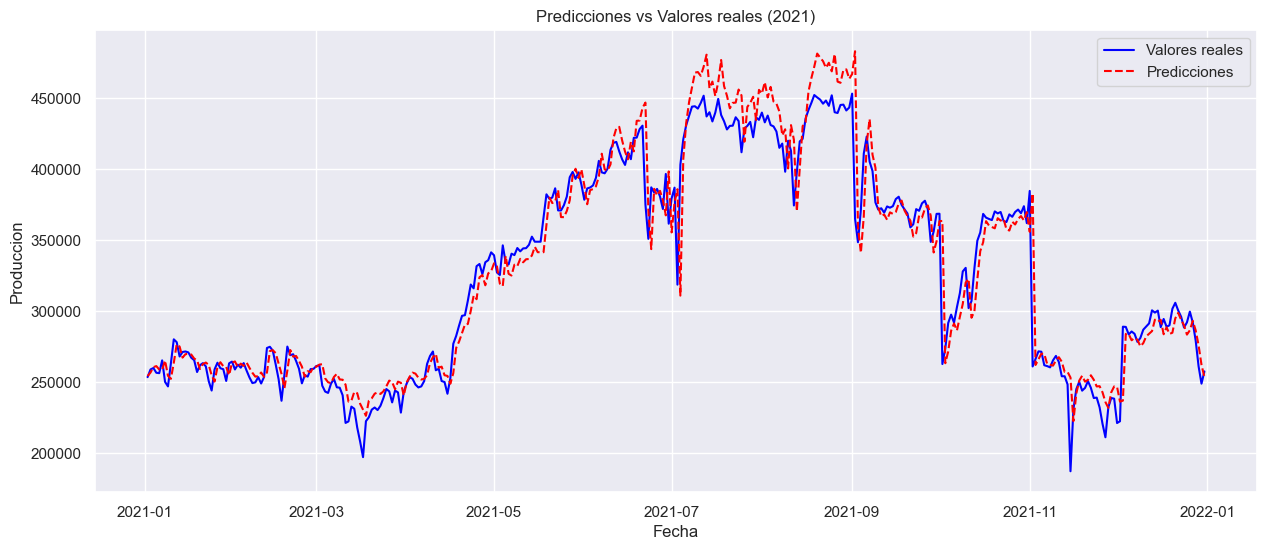

In [92]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Produccion'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Produccion")
plt.legend()
plt.grid(True)
plt.show()

## RNN por horas para predecir la demanda solo con la demanda

In [176]:
dataHoraDemanda = pd.read_csv("datosHorarios.csv")


Epoch 1/50
549/549 [==============================] - 49s 9ms/step - loss: 0.0292 - mae: 0.1009 - val_loss: 0.0031 - val_mae: 0.0430
Epoch 2/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 0.0018 - val_mae: 0.0354
Epoch 3/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 4/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0015 - val_mae: 0.0317
Epoch 5/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0015 - val_mae: 0.0330
Epoch 6/50
549/549 [==============================] - 3s 6ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 7/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 0.0015 - val_mae: 0.0332
Epoch 8/50
549/549 [==============================] - 3s 6ms/step - loss: 0

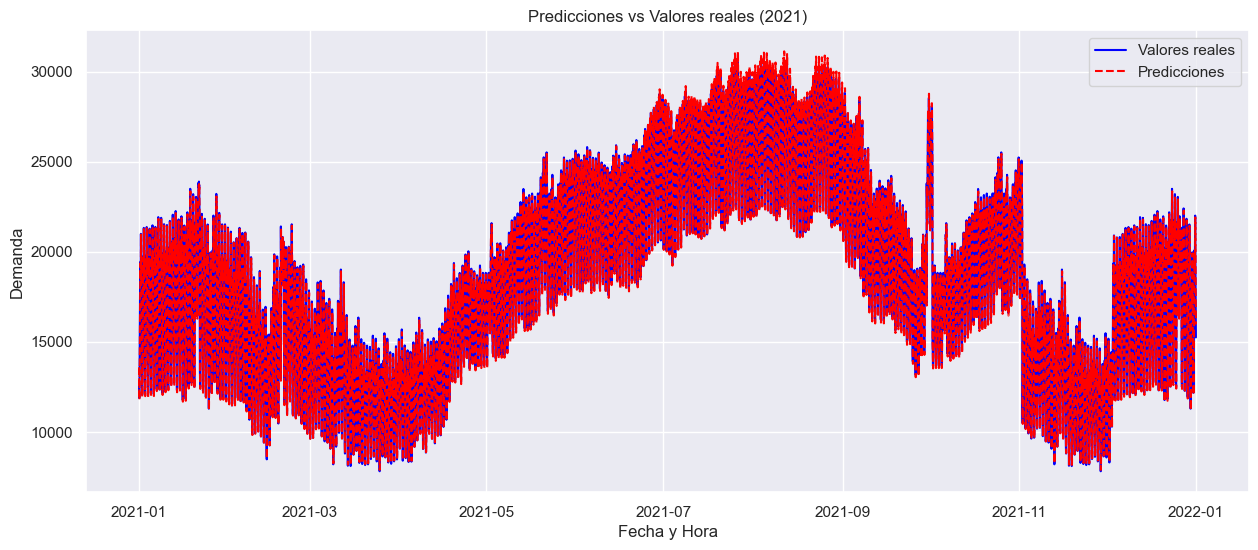

In [177]:

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemanda), freq='H')
dataHoraDemanda.index = date_hour_index

# Extraer solo la columna de demanda
demand = dataHoraDemanda[['Demanda']]

# Separar los datos en entrenamiento y validación
train_data = demand.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = demand.loc['2021-01-01':'2021-12-31 23:00:00']

# Escalar los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

# Preparar los datos para la LSTM
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Comparar las predicciones con los valores reales de 2021
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Demanda'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


In [182]:
# Generar predicciones para el conjunto de validación
predictions = model.predict(X_val)

# Desescalar las predicciones para que estén en la escala original
predictions = scaler.inverse_transform(predictions)

# Crear un DataFrame para comparar los valores reales con las predicciones
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[1:].values, 'Predictions': predictions.flatten()})
print(comparison)

# Calcular el "accuracy" basado en un umbral
threshold = 0.02  # 1% del valor real
correct_predictions = np.abs(predictions.flatten() - val_data['Demanda'].iloc[1:].values) <= threshold * val_data['Demanda'].iloc[1:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


274/274 [==============================] - 1s 3ms/step
      Real Values   Predictions
0           12559  13591.078125
1           11928  12447.388672
2           11879  11833.079102
3           12429  11785.491211
4           13359  12320.598633
...           ...           ...
8754        19597  20737.388672
8755        18253  19522.207031
8756        17179  18134.429688
8757        16117  17039.414062
8758        15250  15967.745117

[8759 rows x 2 columns]
Accuracy basado en un umbral del 2.0%: 24.68%


## RNN por horas para predecir la produccion solo con la produccion


In [184]:
dataHoraProduccion = pd.read_csv("datosHorarios.csv")

Epoch 1/50
549/549 [==============================] - 11s 9ms/step - loss: 0.0451 - mae: 0.1183 - val_loss: 0.0015 - val_mae: 0.0281
Epoch 2/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 0.0015 - val_mae: 0.0277
Epoch 3/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0014 - mae: 0.0270 - val_loss: 0.0013 - val_mae: 0.0247
Epoch 4/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 0.0010 - val_mae: 0.0207
Epoch 5/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0011 - mae: 0.0235 - val_loss: 9.8832e-04 - val_mae: 0.0195
Epoch 6/50
549/549 [==============================] - 4s 6ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 9.5874e-04 - val_mae: 0.0191
Epoch 7/50
549/549 [==============================] - 4s 7ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 9.3504e-04 - val_mae: 0.0185
Epoch 8/50
549/549 [==============================] - 4s 7ms/st

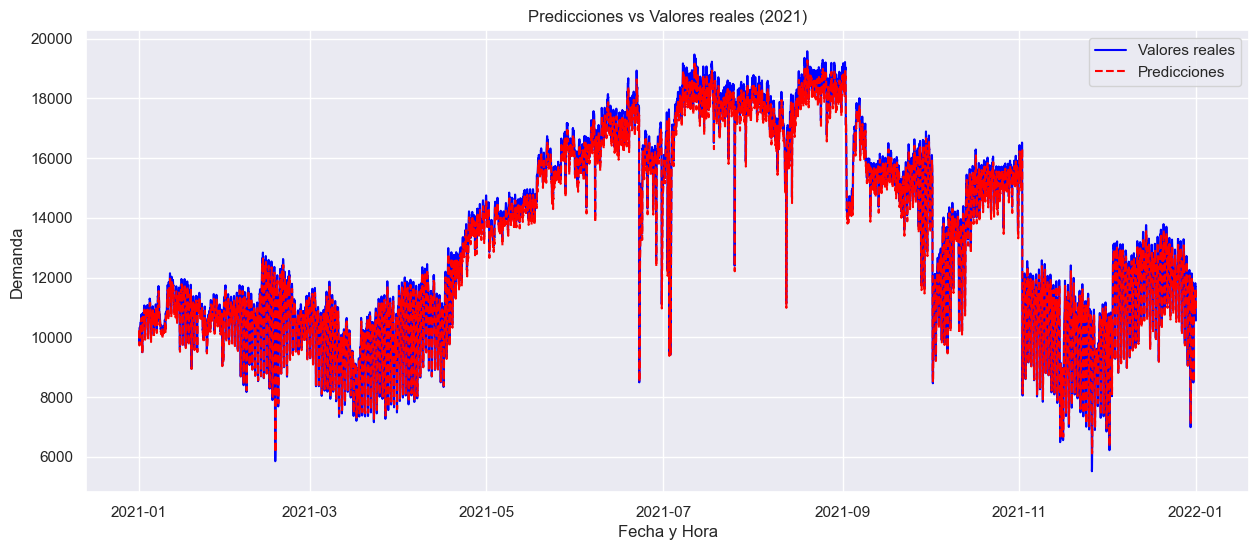

In [186]:

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraProduccion), freq='H')
dataHoraProduccion.index = date_hour_index

# Extraer solo la columna de demanda
produccion = dataHoraProduccion[['Produccion']]

# Separar los datos en entrenamiento y validación
train_data = produccion.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = produccion.loc['2021-01-01':'2021-12-31 23:00:00']

# Escalar los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

# Preparar los datos para la LSTM
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i:i+1])
        y.append(data[i+1])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled)
X_val, y_val = prepare_data(val_scaled)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Comparar las predicciones con los valores reales de 2021
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Visualizar las predicciones frente a los valores reales
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[1:], val_data['Produccion'].iloc[1:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[1:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


In [187]:
# Generar predicciones para el conjunto de validación
predictions = model.predict(X_val)

# Desescalar las predicciones para que estén en la escala original
predictions = scaler.inverse_transform(predictions)

# Crear un DataFrame para comparar los valores reales con las predicciones
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[1:].values, 'Predictions': predictions.flatten()})
print(comparison)

# Calcular el "accuracy" basado en un umbral
threshold = 0.02  # 1% del valor real
correct_predictions = np.abs(predictions.flatten() - val_data['Produccion'].iloc[1:].values) <= threshold * val_data['Produccion'].iloc[1:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


274/274 [==============================] - 1s 3ms/step
      Real Values   Predictions
0           10085  10233.565430
1            9865  10000.820312
2            9792   9793.608398
3            9938   9725.045898
4           10247   9862.266602
...           ...           ...
8754        11690  11639.442383
8755        11691  11522.069336
8756        11472  11523.030273
8757        11025  11313.072266
8758        10560  10887.479492

[8759 rows x 2 columns]
Accuracy basado en un umbral del 2.0%: 59.90%


## LSTM para predecir la demnanda con todas las caracteristicas

In [88]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index

In [94]:
def LSTMDemandaDiaria(time_steps, data):
    # Añadir las estaciones
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    # Añadir las estaciones
    data['Estacion'] = data.index.month.map(assign_season)

    # Marcar los días de Ramadan y Shaaban
    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    # Marcar los días festivos
    festivos = ["01-jan-2019", "06-jan-2019", "01-may-2019", "14-jul-2019", "03-oct-2019",
                "01-jan-2020", "06-jan-2020", "01-may-2020", "14-jul-2020", "03-oct-2020",
                "01-jan-2021", "06-jan-2021", "01-may-2021", "14-jul-2021", "03-oct-2021"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    # Seleccionar las columnas de interés
    features = ["Demanda", "Produccion", "Estacion", "Ramadan", "Shaaban", "Festivo"]
    data_encoded = pd.get_dummies(data[features])
    inputs = data_encoded.values
    target = data['Demanda'].values
    
    # Dividir los datos en entrenamiento y validación
    train_inputs = inputs[:-365]
    val_inputs = inputs[-365-time_steps:]
    
    train_target = target[:-365]
    val_target = target[-365-time_steps:]

    # Escalar los datos
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target.reshape(-1, 1))
    val_target_scaled = target_scaler.transform(val_target.reshape(-1, 1))

    # Preparar los datos para LSTM
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # Visualizar el desempeño del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Comparar las predicciones con los valores reales de 2021
    predictions = model.predict(X_val)


In [110]:


def LSTMDemandaDiaria2(time_steps, data):
    # Función para asignar estaciones
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    # Añadir las estaciones
    data['Estacion'] = data.index.month.map(assign_season)

    # One-hot encoding de las estaciones
    data = pd.get_dummies(data, columns=['Estacion'])

    # Marcar los días de Ramadan y Shaaban
    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    # Marcar los días festivos
    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    # Seleccionar las columnas de interés
    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    # Dividir los datos en entrenamiento y validación
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]

    # Escalar los datos
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    # Preparar los datos para LSTM
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # Visualizar el desempeño del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Comparar las predicciones con los valores reales de 2021
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    # Tabla comparativa
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    # Calcular precisión basada en un umbral
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    # Visualizar las predicciones frente a los valores reales
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()



Epoch 1/50
23/23 [==============================] - 4s 28ms/step - loss: 0.1030 - val_loss: 0.0227
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0121 - val_loss: 0.0177
Epoch 3/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0148
Epoch 4/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0131
Epoch 5/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0112
Epoch 6/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0101
Epoch 7/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0107
Epoch 8/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 9/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0104
Epoch 10/50
23/23 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0100
Epoch 11/

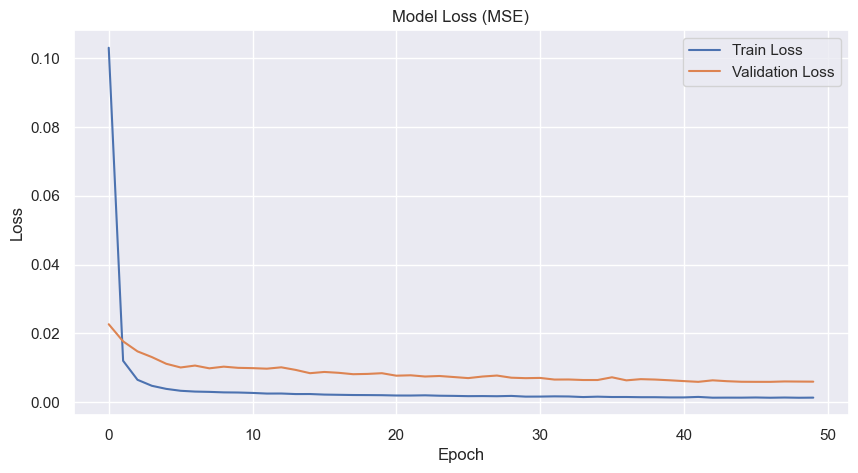

12/12 [==============================] - 0s 4ms/step
     Real Values   Predictions
0         415824  434743.93750
1         410048  422446.34375
2         412486  422159.43750
3         416401  425802.93750
4         422912  431958.56250
..           ...           ...
355       411592  430970.53125
356       378184  420478.25000
357       414996  403689.31250
358       437452  399467.96875
359       417780  409694.06250

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 18.06%


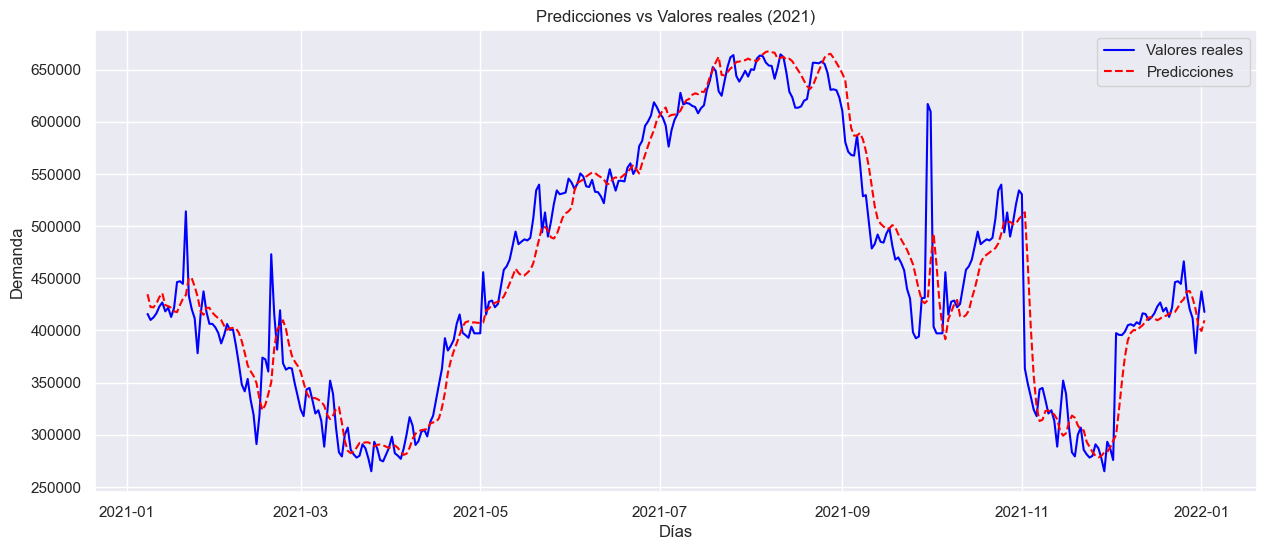

In [111]:
LSTMDemandaDiaria2(7, dataFullCaracteristicas)

## LSTM para predecir la demanda con todas las caracteristicas por horas

In [66]:


dataHoras= pd.read_csv("datosHorarios.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataHoras), freq='D')
dataHoras.index = date_index

In [67]:
dataHoras

Produccion  Hours  Demanda
2019-01-01       10494      1    11479
2019-01-02        9914      2    10595
2019-01-03        9452      3    10132
2019-01-04        9334      4    10437
2019-01-05        9832      5    11576
...                ...    ...      ...
2091-02-19       12754     20    19725
2091-02-20       12639     21    18376
2091-02-21       12320     22    17323
2091-02-22       11802     23    16220
2091-02-23       11000     24    15341

[26352 rows x 3 columns]

In [68]:


def LSTMDemandaHoraria(time_steps, data):
    # Función para asignar estaciones
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    # Añadir las estaciones
    data['Estacion'] = data.index.month.map(assign_season)

    # One-hot encoding de las estaciones
    data = pd.get_dummies(data, columns=['Estacion'])
    
    # Asegurarse de que todas las estaciones estén presentes
    estaciones = ['Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera', 'Estacion_Verano']
    for estacion in estaciones:
        if estacion not in data.columns:
            data[estacion] = 0

    # Marcar las horas de Ramadan y Shaaban
    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='H'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='H'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='H')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='H'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='H'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='H')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    # Marcar las horas festivas
    festivos = pd.to_datetime(["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                               "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                               "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"])
    festivos_hours = [pd.date_range(start=f, end=f + pd.Timedelta(days=1), freq='H') for f in festivos]
    
    data['Festivo'] = data.index.isin(np.concatenate(festivos_hours)).astype(int)

    # Seleccionar las columnas de interés
    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    # Dividir los datos en entrenamiento y validación
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    # Escalar los datos
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    # Preparar los datos para LSTM
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # Visualizar el desempeño del entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Comparar las predicciones con los valores reales de 2021
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    # Tabla comparativa
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    # Calcular precisión basada en un umbral
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    # Visualizar las predicciones frente a los valores reales
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Horas")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/50
23/23 [==============================] - 10s 328ms/step - loss: 0.1356 - val_loss: 0.1005
Epoch 2/50
23/23 [==============================] - 7s 314ms/step - loss: 0.0622 - val_loss: 0.0835
Epoch 3/50
23/23 [==============================] - 7s 315ms/step - loss: 0.0580 - val_loss: 0.1058
Epoch 4/50
23/23 [==============================] - 7s 306ms/step - loss: 0.0542 - val_loss: 0.1147
Epoch 5/50
23/23 [==============================] - 7s 306ms/step - loss: 0.0510 - val_loss: 0.1285
Epoch 6/50
23/23 [==============================] - 6s 288ms/step - loss: 0.0410 - val_loss: 0.1420
Epoch 7/50
23/23 [==============================] - 7s 305ms/step - loss: 0.0275 - val_loss: 0.1538
Epoch 8/50
23/23 [==============================] - 6s 293ms/step - loss: 0.0202 - val_loss: 0.1121
Epoch 9/50
23/23 [==============================] - 6s 287ms/step - loss: 0.0123 - val_loss: 0.0638
Epoch 10/50
23/23 [==============================] - 7s 296ms/step - loss: 0.0110 - val_loss: 0.069

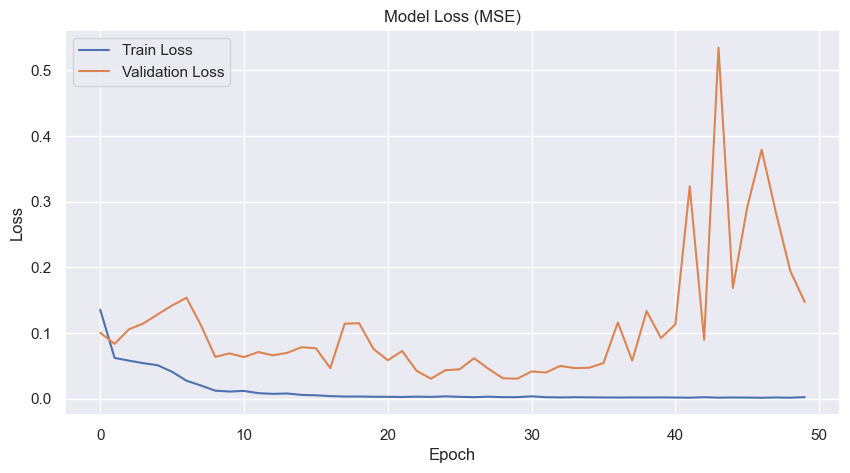

800/800 [==============================] - 10s 12ms/step
       Real Values   Predictions
0            17503  17591.857422
1            17483  17760.773438
2            17483  18008.177734
3            17059  18259.884766
4            18779  18370.068359
...            ...           ...
25591        19725  19665.978516
25592        18376  18909.394531
25593        17323  18153.839844
25594        16220  17244.150391
25595        15341  15943.610352

[25596 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 10.72%


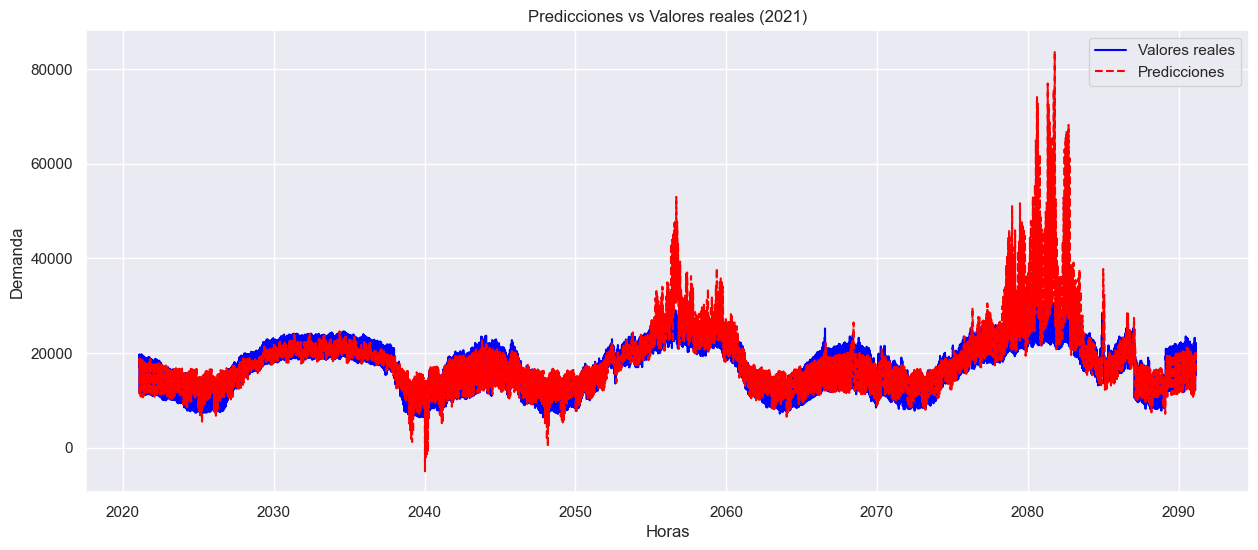

In [70]:
LSTMDemandaHoraria(24,dataHoras)

## Predicción según meses

In [93]:
dataPredMes = data.copy()
dataPredMes

NameError: name 'data' is not defined

In [111]:
data1_19_20 = dataPredMes[(dataPredMes.index.month == 4) & (dataPredMes.index.year <= 2020)]
data1_21 = dataPredMes[(dataPredMes.index.month == 1) & (dataPredMes.index.year == 2021)]

In [112]:
train_data  = data1_19_20
train_data = train_data.drop('Produccion', axis=1)
train_data

Demanda
fecha              
2019-04-01   286390
2019-04-02   283185
2019-04-03   281100
2019-04-04   273165
2019-04-05   270548
2019-04-06   273851
2019-04-07   276671
2019-04-08   274952
2019-04-09   273243
2019-04-10   277249
2019-04-11   277577
2019-04-12   275304
2019-04-13   277056
2019-04-14   275659
2019-04-15   277416
2019-04-16   282269
2019-04-17   280209
2019-04-18   277804
2019-04-19   276820
2019-04-20   277358
2019-04-21   274310
2019-04-22   271071
2019-04-23   271005
2019-04-24   265778
2019-04-25   273833
2019-04-26   272873
2019-04-27   275624
2019-04-28   284252
2019-04-29   295115
2019-04-30   297353
2020-04-01   262326
2020-04-02   265847
2020-04-03   260356
2020-04-04   260415
2020-04-05   260290
2020-04-06   261459
2020-04-07   262692
2020-04-08   269437
2020-04-09   272344
2020-04-10   282602
2020-04-11   288420
2020-04-12   284245
2020-04-13   277975
2020-04-14   275214
2020-04-15   272721
2020-04-16   270850
2020-04-17   274349
2020-04-18   282000
2020-04-19   283465
2020-04-20   279172
2020-04-21   288504
2020-04-22   309798
2020-04-23   324502
2020-04-24   342249
2020-04-25   352359
2020-04-26   371136
2020-04-27   344921
2020-04-28   325709
2020-04-29   325771
2020-04-30   316859

In [113]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

In [114]:
timesteps = 62

In [115]:

def create_sequences(data):
    X, y = [], []
    for i in range(len(data)-timesteps-1):
        X.append(data[i:(i+timesteps), 0])
        y.append(data[(i+timesteps), 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [116]:
X_train, y_train = create_sequences(train_data_scaled)

In [118]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

IndexError: tuple index out of range

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
1/1 - 3s - loss: 0.1555 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.1361 - 20ms/epoch - 20ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1191 - 22ms/epoch - 22ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1042 - 21ms/epoch - 21ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0912 - 23ms/epoch - 23ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0802 - 20ms/epoch - 20ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0714 - 18ms/epoch - 18ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0650 - 18ms/epoch - 18ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0615 - 20ms/epoch - 20ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0613 - 18ms/epoch - 18ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0641 - 19ms/epoch - 19ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0676 - 16ms/epoch - 16ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0693 - 19ms/epoch - 19ms/step
Epoch 14/100
1/1 - 0s - loss: 0.0686 - 15ms/epoch - 15ms/step
Epoch 15/100
1/1 - 0s - loss: 0.0663 - 17ms/epoch - 17ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0636 - 16ms/epoch - 16ms/step
Epoch 17/100
1/1 - 0s

In [ ]:
last_data = train_data_scaled[-timesteps:]
pred_values = []
for i in range(31):
    test_data_seq = last_data[-timesteps:]
    test_data_seq = test_data_seq.reshape(1, timesteps, 1)
    pred = model.predict(test_data_seq)
    pred_values.append(pred[0][0])
    last_data = np.append(last_data, pred)[1:]

1/1 [==============================] - 0s 23ms/step


In [ ]:
pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))

In [ ]:
for i, value in enumerate(pred_values):
    print("La demanda para el día", i+1, "de enero de 2021 es:", value[0])

La demanda para el día 1 de enero de 2021 es: 258554.78
La demanda para el día 2 de enero de 2021 es: 257502.66
La demanda para el día 3 de enero de 2021 es: 256607.48
La demanda para el día 4 de enero de 2021 es: 255845.81
La demanda para el día 5 de enero de 2021 es: 255237.47
La demanda para el día 6 de enero de 2021 es: 254766.58
La demanda para el día 7 de enero de 2021 es: 254438.48
La demanda para el día 8 de enero de 2021 es: 254229.55
La demanda para el día 9 de enero de 2021 es: 254029.19
La demanda para el día 10 de enero de 2021 es: 253864.6
La demanda para el día 11 de enero de 2021 es: 253758.48
La demanda para el día 12 de enero de 2021 es: 253696.56
La demanda para el día 13 de enero de 2021 es: 253666.06
La demanda para el día 14 de enero de 2021 es: 253645.9
La demanda para el día 15 de enero de 2021 es: 253640.44
La demanda para el día 16 de enero de 2021 es: 253615.64
La demanda para el día 17 de enero de 2021 es: 253594.44
La demanda para el día 18 de enero de 2021

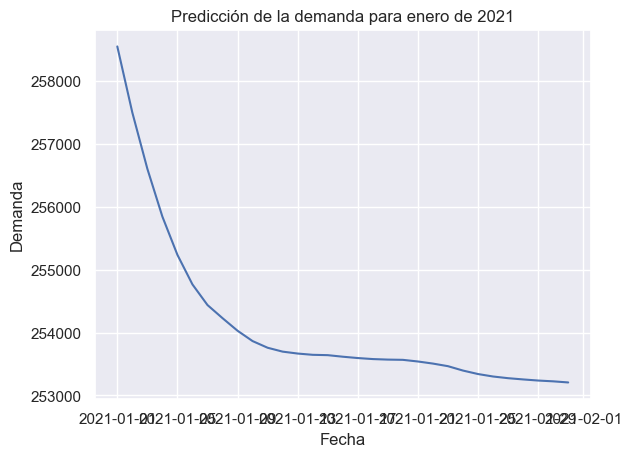

In [ ]:
fechas = [datetime.date(2021, 1, i+1) for i in range(len(pred_values))]
plt.plot(fechas, pred_values)
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Predicción de la demanda para enero de 2021')
plt.show()

In [ ]:
def demanda_segun_mes(mes,look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data  = data1_19_20.copy()
    train_data = train_data.drop('Produccion', axis=1)
    train_data
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data  = data1_21.copy()
    val_data  = val_data .drop('Produccion', axis=1)
    val_data 
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    X, y = [], []
    for i in range(len(train_data_scaled)-timesteps-1):
        X.append(train_data_scaled[i:(i+timesteps), 0])
        y.append(train_data_scaled[(i+timesteps), 0])
    X_train = np.array(X)
    y_train = np.array(y)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(timesteps, 1), return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)
    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(look_back):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(fechas, val_data, label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()


    return pred_values

Epoch 1/100
1/1 - 5s - loss: 0.3730 - 5s/epoch - 5s/step
Epoch 2/100
1/1 - 0s - loss: 0.2716 - 63ms/epoch - 63ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1903 - 57ms/epoch - 57ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1299 - 52ms/epoch - 52ms/step
Epoch 5/100
1/1 - 0s - loss: 0.1052 - 48ms/epoch - 48ms/step
Epoch 6/100
1/1 - 0s - loss: 0.1311 - 51ms/epoch - 51ms/step
Epoch 7/100
1/1 - 0s - loss: 0.1402 - 51ms/epoch - 51ms/step
Epoch 8/100
1/1 - 0s - loss: 0.1227 - 53ms/epoch - 53ms/step
Epoch 9/100
1/1 - 0s - loss: 0.1048 - 55ms/epoch - 55ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0963 - 47ms/epoch - 47ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0954 - 46ms/epoch - 46ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0978 - 47ms/epoch - 47ms/step
Epoch 13/100
1/1 - 0s - loss: 0.1003 - 47ms/epoch - 47ms/step
Epoch 14/100
1/1 - 0s - loss: 0.1012 - 50ms/epoch - 50ms/step
Epoch 15/100
1/1 - 0s - loss: 0.1002 - 50ms/epoch - 50ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0976 - 48ms/epoch - 48ms/step
Epoch 17/100
1/1 - 0s

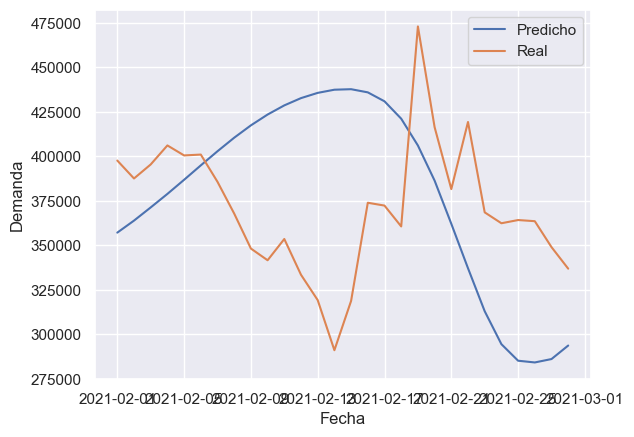

array([[357156.97],
       [363914.12],
       [371325.03],
       [378913.44],
       [386857.53],
       [394952.06],
       [402900.56],
       [410503.  ],
       [417445.22],
       [423524.1 ],
       [428666.94],
       [432750.53],
       [435696.28],
       [437478.  ],
       [437764.16],
       [435987.12],
       [430956.53],
       [421189.16],
       [406128.66],
       [386391.4 ],
       [362131.47],
       [337141.56],
       [312984.22],
       [294472.34],
       [285173.06],
       [284202.  ],
       [286113.47],
       [293704.72]], dtype=float32)

In [ ]:
demanda_segun_mes(2,28)

In [ ]:

def demanda_segun_mes2(mes, look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data = data1_19_20.drop('Produccion', axis=1)
    
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data = data1_21.drop('Produccion', axis=1)
    
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    
    X_train, y_train = [], []
    for i in range(len(train_data_scaled) - look_back - 1):
        X_train.append(train_data_scaled[i:(i + look_back), 0])
        y_train.append(train_data_scaled[(i + look_back), 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    layers = 1
    units = 128
    return_sequence = False
    recurrent_dropout = 0
    dense_dropout = 0.2
    dense_layers = [32, 64, 128]

    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in range(layers - 1):
        model.add(LSTM(units, return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in dense_layers:
        model.add(Dense(i, activation='relu'))
        model.add(Dropout(dense_dropout))
    model.add(Dense(1))

    optimizer = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    batch_size = 64
    epochs = 200
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(len(val_data)):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(val_data.index, val_data['Demanda'], label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()

    return pred_values


Epoch 1/200
1/1 - 3s - loss: 0.3570 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 0.3339 - 34ms/epoch - 34ms/step
Epoch 3/200
1/1 - 0s - loss: 0.2953 - 38ms/epoch - 38ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2564 - 37ms/epoch - 37ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2290 - 35ms/epoch - 35ms/step
Epoch 6/200
1/1 - 0s - loss: 0.1873 - 34ms/epoch - 34ms/step
Epoch 7/200
1/1 - 0s - loss: 0.1458 - 36ms/epoch - 36ms/step
Epoch 8/200
1/1 - 0s - loss: 0.1373 - 34ms/epoch - 34ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0997 - 37ms/epoch - 37ms/step
Epoch 10/200
1/1 - 0s - loss: 0.1103 - 37ms/epoch - 37ms/step
Epoch 11/200
1/1 - 0s - loss: 0.1543 - 35ms/epoch - 35ms/step
Epoch 12/200
1/1 - 0s - loss: 0.1455 - 43ms/epoch - 43ms/step
Epoch 13/200
1/1 - 0s - loss: 0.1022 - 32ms/epoch - 32ms/step
Epoch 14/200
1/1 - 0s - loss: 0.1076 - 30ms/epoch - 30ms/step
Epoch 15/200
1/1 - 0s - loss: 0.0927 - 31ms/epoch - 31ms/step
Epoch 16/200
1/1 - 0s - loss: 0.1012 - 38ms/epoch - 38ms/step
Epoch 17/200
1/1 - 0s

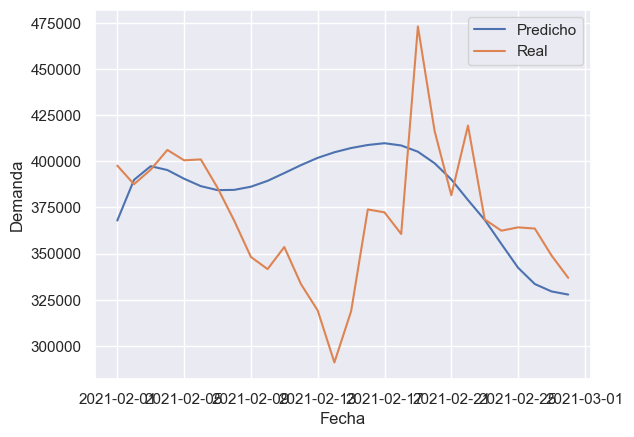

array([[367924.47],
       [389946.7 ],
       [397349.03],
       [395276.38],
       [390564.6 ],
       [386556.2 ],
       [384395.1 ],
       [384531.62],
       [386243.72],
       [389421.7 ],
       [393630.4 ],
       [397942.25],
       [401870.72],
       [404898.1 ],
       [407188.2 ],
       [408839.5 ],
       [409799.8 ],
       [408577.  ],
       [405196.12],
       [398946.5 ],
       [390177.5 ],
       [379021.66],
       [368295.53],
       [355223.12],
       [342360.8 ],
       [333547.38],
       [329540.66],
       [327840.78]], dtype=float32)

In [ ]:
demanda_segun_mes2(2, 28)